#**Clinical Proteomics of Rhabdomyolysis: Molecular Insights Toward Early Detection**


#Background

##Introduction
Rhabdomyolysis begins with muscle injury triggered by physical trauma, chemical toxicity, or metabolic stress. Once initiated, a cascade of internal disruption unfolds, marked by the rapid breakdown of skeletal muscle tissue. This condition presents a significant clinical challenge due to its variable presentation and potential for severe complications, including acute kidney injury. Early detection is often hindered by nonspecific symptoms and delayed laboratory findings, which can impede timely intervention. Furthermore, current diagnostic markers lack the sensitivity and specificity needed to reliably predict disease progression. Improved early detection strategies and validated biomarkers are critically needed to enhance patient outcomes, guide clinical decisions, and prevent irreversible organ damage.

##Method
Twenty-five healthy young individuals were studied under highly controlled conditions. Venous blood samples were collected before and after experimentally induced muscle damage (rhabdomyolysis). Following injury, participants were randomized into two groups: one receiving a placebo and the other receiving Growth Hormone (GH). Each participant underwent five blood draws: (1) before muscle damage, (2) on the day of injury (post injury and prior to GH or placebo administration), (3) 3–5 days post-injury, (4) 7 days post-injury, and (5) 14 days post-injury—yielding a total of 125 plasma samples. All samples were processed and analyzed using high-throughput liquid chromatography–mass spectrometry (LC-MS). Additionally, two clinical outcome measures were assessed: creatine kinase (CK) from routine lab testing as an indicator of acute muscle damage, and the percentage of dystrophic muscle fibers assessed 7 days post-injury as a marker of chronic muscle damage.

##Objective
To comprehensively characterize the proteomic response to acute muscle injury (rhabdomyolysis) and evaluate how this response evolves over time and under the influence of Growth Hormone treatment. This study aims to identify protein signatures associated with distinct phases of muscle damage and recovery, assess correlations with clinical markers such as creatine kinase, and explore whether proteomic profiles can predict longer-term outcomes such as the percentage of dystrophic fibers. Additionally, the data may reveal early biomarkers for timely detection and risk stratification of muscle injury, which are critical for preventing complications and guiding intervention. These findings could also contribute to the development of progression markers, therapeutic targets, and deeper insights into the molecular mechanisms of muscle repair and degeneration, ultimately informing future diagnostic and personalized treatment strategies.

##Data
Attached are 2 data files:

**1)Rhabdomyolysis.xlsx:** meta data
* “subject”: subject id
* “sample”: sample id, corresponding to the column name in the proteomics data
* “visit”: the time/visit the sample was collected
* “treatment”: the treatment group the individual was in (GH/Placebo)
* “dystrophy (%)”: percentage muscle dystrophy measured at day 7 after injury
* “CK (U/L)”: creatine kinase measured with routine lab testing

**2)Rhabdomyolysis.tsv:** MS proteomics data.
Samples are columns and proteins are rows. Data has been analyzed from raw data with Spectronaut and subsequently log2 transformed.

#Preprocessing

##Loading the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [98]:
import pandas as pd

meta = pd.read_excel('/content/drive/My Drive/rhabdomyolysis/rhabdomyolysis.xlsx')
proteomes = pd.read_csv('/content/drive/My Drive/rhabdomyolysis/rhabdomyolysis.tsv', sep='\t')
proteomes = proteomes.set_index('Protein.Ids')
proteomes = proteomes.drop(['Protein.Names', 'Genes'], axis=1)



In [99]:
#verify all samples are present in both datasets
meta_samples = set(meta['sample'])
proteomes_columns = set(proteomes.columns)
print(meta_samples.issubset(proteomes_columns))
print(proteomes_columns.issubset(meta_samples))

True
True


##Missingness

In [5]:
#quantify missingness
print(f"Missing per sample:\n{proteomes.isnull().sum()}\n")
print(f"Fraction missing per sample:\n{proteomes.isnull().mean()}\n")

print(f"Missing per protein:\n{proteomes.isnull().sum(axis=1)}\n")
print(f"Fraction missing per protein:\n{proteomes.isnull().mean(axis=1)}\n")

Missing per sample:
S1      154
S2      140
S3      156
S4      178
S5      745
       ... 
S142    175
S143    138
S146    161
S147    151
S148    140
Length: 125, dtype: int64

Fraction missing per sample:
S1      0.165770
S2      0.150700
S3      0.167922
S4      0.191604
S5      0.801938
          ...   
S142    0.188375
S143    0.148547
S146    0.173305
S147    0.162540
S148    0.150700
Length: 125, dtype: float64

Missing per protein:
Protein.Ids
A0A0G2JRN3;A0A024R6I7                                                                                                                              54
A0A804HIW2;A0A067XG54                                                                                                                              10
A0A075B6H7;A0A0C4DH90;A0A0C4DH55;P01624                                                                                                             7
A0A075B6H9                                                                                   

In [6]:
#quantify missingness pt2
fraction_missing = proteomes.isnull().mean(axis=1)
proteins_high_missing = proteomes[fraction_missing > 0.2]
print(f"proteins with missingness > 20%: {len(proteins_high_missing.index)}/{len(proteomes.index)}")
print(proteins_high_missing.isnull().mean(axis=1).sort_values(ascending=False))

proteins with missingness > 20%: 336/929
Protein.Ids
P00387;P00387-2;P00387-3;A0A8I5QKX1;A0A8I5QKT9;A0A8I5QKL2;B1AHF3;A0A8J8Z3C6;A0A8J8YWN6;A0A8I5KNV1;A0A8I5KPU0;A0A8I5KR71;A0A8I5KUA5;A0A8I5KTF9;A0A8I5KW26;A0A8I5KVD2;A0A8I5KYU1;A0A8I5KXI5    1.000
Q99879;P57053;Q5QNW6;Q16778;O60814;P62807;P23527;P06899;Q99880;Q99877;P33778;Q93079;Q8N257;Q96A08;P58876;U3KQK0;Q5QNW6-2                                                                     0.992
Q86YT9;A0A1W2PRS4;E9PR26;E9PKK2;Q86YT9-3;Q86YT9-4;Q86YT9-2                                                                                                                                   0.984
P55209;H0YIV4;H0YHC3;P55209-2;P55209-3;H0YH88;F8VXI6;F8VY35;F8VVB5;F8VUX1;F8VV59;F8W543;F8VRJ2;F8W118;F8W0J6;F8W020;B7Z9C2;F5H4R6                                                            0.984
Q86YZ3                                                                                                                                                                 

Before imputations it's important to filter out those rows and columns that have way too much missingness to be imputed. We do data science, not miracles.

In [7]:
proteomes_filtered = proteomes[fraction_missing <= 0.2]
proteomes_filtered = proteomes_filtered.loc[:, proteomes_filtered.isnull().mean() <= 0.3]
#proteomes_filtered.to_csv('/content/drive/My Drive/rhabdomyolysis/proteomes_filtered.csv')

###Missingness-intensity correlation

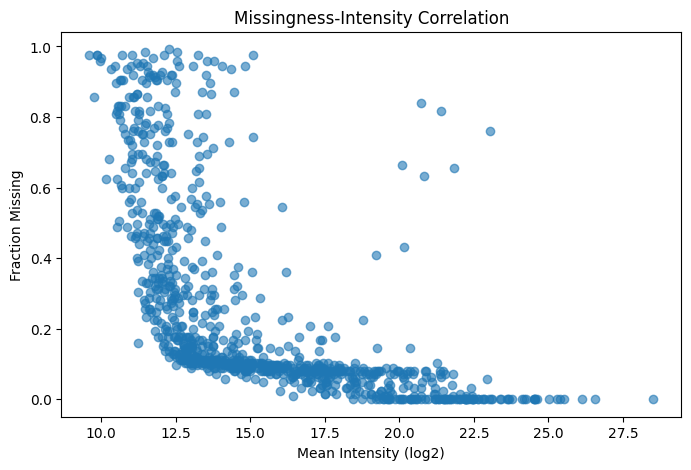

Spearman correlation: -0.857
Pearson correlation: -0.617


In [8]:
import matplotlib.pyplot as plt

mean_intensity = proteomes.mean(axis=1, skipna=True)
fraction_missing = proteomes.isnull().mean(axis=1)

#scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(mean_intensity, fraction_missing, alpha=0.6)
plt.xlabel('Mean Intensity (log2)')
plt.ylabel('Fraction Missing')
plt.title('Missingness-Intensity Correlation')
plt.show()

#correlation coefficient
correlation = mean_intensity.corr(fraction_missing, method='spearman')
print(f"Spearman correlation: {correlation:.3f}")
correlation = mean_intensity.corr(fraction_missing, method='pearson')
print(f"Pearson correlation: {correlation:.3f}")

Given the results, the data is MNAR and there is a high correlation between the missingness and the mean intensity of each biomarker. Therefore, it would be sensible to attempt imputation for biomarkers with a missingness < 20%.
Common with proteomic data due to the intensities being below the instrument's sensitivity.

##Imputation

In [14]:
!pip install pimms-learn

  Using cached pimms_learn-0.5.0-py3-none-any.whl.metadata (21 kB)
  Using cached njab-0.1.1-py3-none-any.whl
  Using cached mrmr_selection-0.2.8-py3-none-any.whl.metadata (6.6 kB)
  Using cached pingouin-0.5.5-py3-none-any.whl.metadata (19 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached category_encoders-2.8.1-py3-none-any.whl.metadata (7.9 kB)
  Using cached pandas_flavor-0.7.0-py3-none-any.whl.metadata (6.7 kB)
Using cached pimms_learn-0.5.0-py3-none-any.whl (91 kB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
Using cached mrmr_selection-0.2.8-py3-none-any.whl (15 kB)
Using cached pingouin-0.5.5-py3-none-any.whl (204 kB)
Using cached category_encoders-2.8.1-py3-none-any.whl (85 kB)
Using cached pandas_flavor-0.7.0-py3-none-any.whl (8.4 kB)


In [10]:
proteomes_filtered = proteomes_filtered.transpose()
print(proteomes_filtered.head())
#samples should be row, proteins should be columns

Protein.Ids  A0A804HIW2;A0A067XG54  A0A075B6H7;A0A0C4DH90;A0A0C4DH55;P01624  \
S1                       16.456411                                22.982053   
S2                       15.883712                                23.236985   
S3                       17.003463                                22.772110   
S4                       17.016689                                23.058885   
S6                       17.649018                                23.316226   

Protein.Ids  A0A075B6H9  A0A075B6I0  A0A075B6I1  A0A075B6I9  A0A075B6J1  \
S1            17.972363   20.593829   15.530891   20.943136   15.634638   
S2            18.085524   20.641794   15.494124   21.018692   15.893228   
S3            17.828769   20.378375   15.194884   20.676771   15.300474   
S4            17.508886   20.178730   15.366797   20.607800   15.670316   
S6            17.680408   20.141508   12.034242   20.879242   15.385178   

Protein.Ids  A0A075B6J9  A0A075B6K0  A0A075B6K2  ...     Q9Y490  \
S1     

In [11]:
proteomes_filtered.index.name = "Sample ID"
proteomes_filtered.columns.name = "protein group"
proteomes_stack = proteomes_filtered.stack().to_frame('intensity')
proteomes_stack

intensity
Sample ID protein group                                                
S1        A0A804HIW2;A0A067XG54                               16.456411
          A0A075B6H7;A0A0C4DH90;A0A0C4DH55;P01624             22.982053
          A0A075B6H9                                          17.972363
          A0A075B6I0                                          20.593829
          A0A075B6I1                                          15.530891
...                                                                 ...
S148      Q9Y646                                              12.758916
          Q9Y6R7;A0A087WXI2                                   16.024480
          Q9Y6Y1;H0YJR7;A0A8V8TQA4;A0A8V8TQX9;A0A8V8TR82;...  11.853228
          Q9Y6Z7                                              14.524793
          V9GYM3                                              11.577896

[65612 rows x 1 columns]

###Collaborative Filtering

In [15]:
import pimmslearn.sampling
from pimmslearn.sklearn.cf_transformer import CollaborativeFilteringTransformer

#split dataset
splits, thresholds, fake_na_mcar, fake_na_mnar = pimmslearn.sampling.sample_mnar_mcar(
    df_long=proteomes_stack,
    frac_non_train=0.1,
    frac_mnar=0.5,
    random_state=42,
)
print(f"Length of fake_na: {len(fake_na_mcar) + len(fake_na_mnar)}")
print(f"Length of splits.train_X: {len(splits.train_X)}")
print(f"Length of df_long: {len(proteomes_stack)}")
splits = pimmslearn.sampling.check_split_integrity(splits)



/usr/local/lib/python3.11/dist-packages/pimmslearn/sampling.py:209: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  loc=float(quantile_frac),
/usr/local/lib/python3.11/dist-packages/pimmslearn/sampling.py:210: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  scale=float(0.3 * df_long.std()),


Length of fake_na: 6560
Length of splits.train_X: 59052
Length of df_long: 65612


In [16]:
cf_model = CollaborativeFilteringTransformer(
    target_column='intensity',
    sample_column='Sample ID',
    item_column='protein group',
    out_folder='runs/scikit_interface')

suggested_lr.valley = 0.00912


epoch,train_loss,valid_loss,time
0,12.617476,22.316282,00:00
1,12.185594,20.097141,00:00
2,10.929108,12.329227,00:00
3,8.080853,1.308613,00:00
4,5.683552,0.617707,00:00
5,4.107058,0.621621,00:00


No improvement since epoch 4: early stopping


CollaborativeFilteringTransformer(item_column='protein group',
                                  out_folder=Path('runs/scikit_interface'),
                                  sample_column='Sample ID',
                                  target_column='intensity')

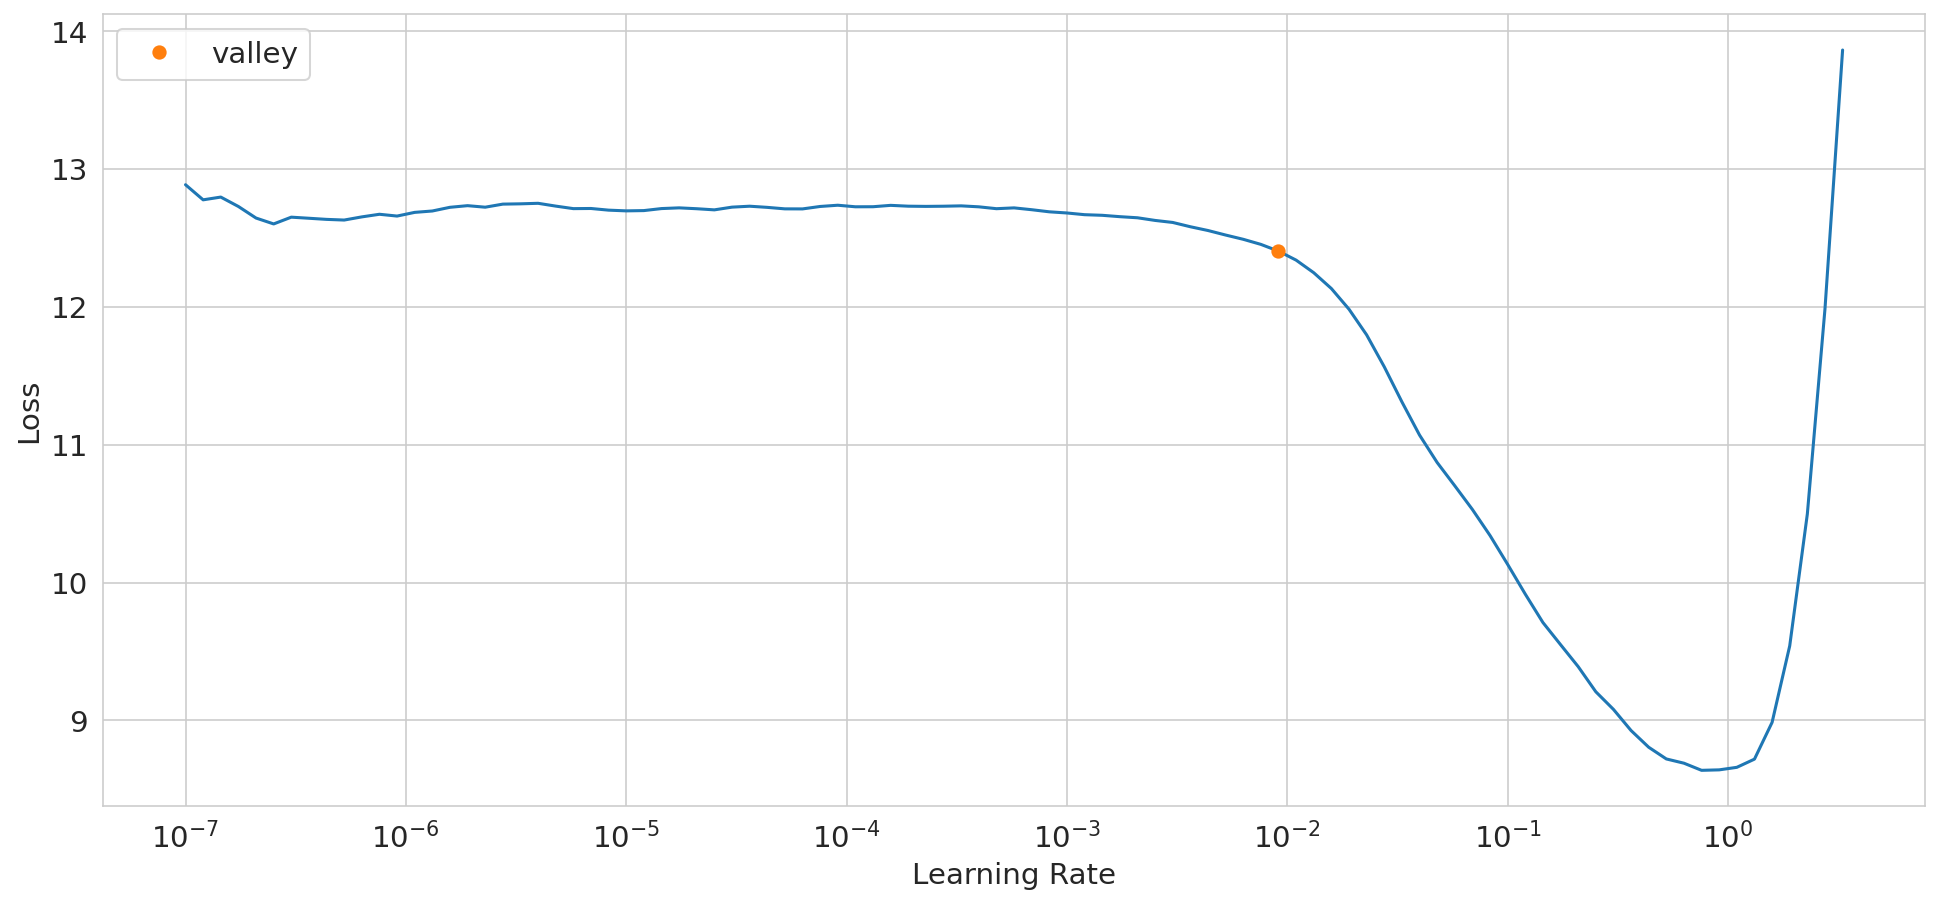

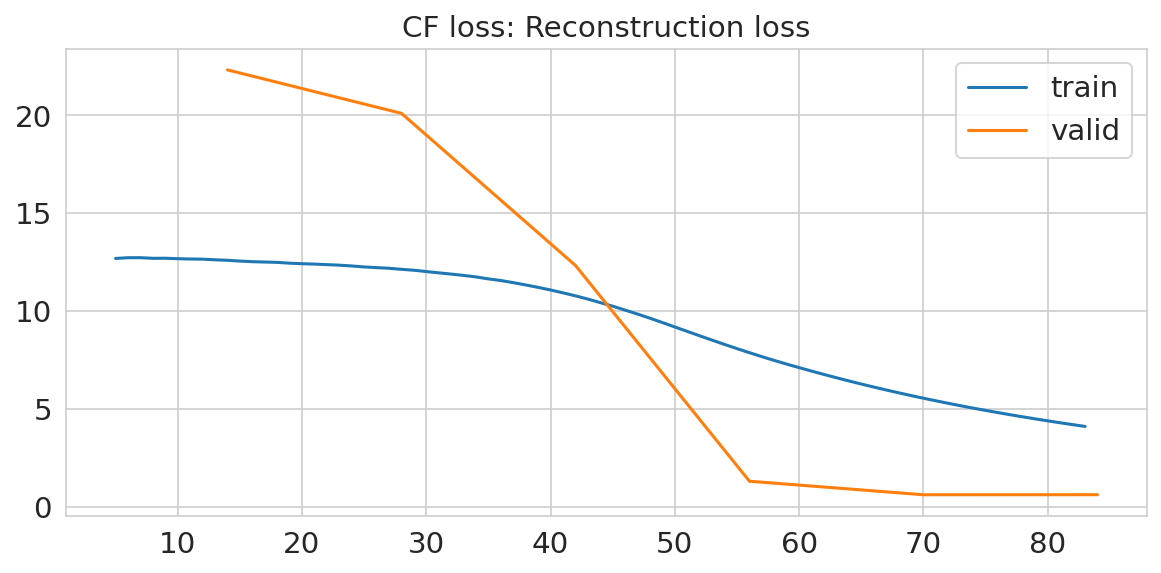

In [17]:
cf_model.fit(splits.train_X,
             splits.val_y,
             cuda=False,
             epochs_max=20,
             )

The test and validation loss converge around 0.6 within 20 epochs, indicating good model performance

In [18]:
proteomes_imputed = cf_model.transform(proteomes_stack).unstack()

#check that all NAs have been imputed
assert proteomes_imputed.isna().sum().sum() == 0
proteomes_imputed.head()

protein group,A0A804HIW2;A0A067XG54,A0A075B6H7;A0A0C4DH90;A0A0C4DH55;P01624,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I9,A0A075B6J1,A0A075B6J9,A0A075B6K0,A0A075B6K2,...,Q9Y490,Q9Y4L1;A0A494C039;K7EQK2;A0A087X054,Q9Y5C1,Q9Y5F6-2,Q9Y5Y7,Q9Y646,Q9Y6R7;A0A087WXI2,Q9Y6Y1;H0YJR7;A0A8V8TQA4;A0A8V8TQX9;A0A8V8TR82;A0A8V8TR85;A0A8V8TPP2;A0A8V8TPQ2;A0A8V8TQ65;A0A8V8TQ84;A0A8V8TQ87;A0A8V8TQ98;Q9Y6Y1-2;A0A0C4DGL0,Q9Y6Z7,V9GYM3
Sample ID,,,,,,,,,,,,,,,,,,,,,
S1,16.456,22.982,17.972,20.594,15.531,20.943,15.635,18.328,15.838,11.508,...,14.924,14.225,13.218,17.868,16.611,12.557,16.870,11.294,14.983,13.577
S2,15.884,23.237,18.086,20.642,15.494,21.019,15.893,18.192,15.596,11.884,...,15.470,14.247,12.922,18.047,16.608,12.699,16.800,11.750,14.901,14.304
S3,17.003,22.772,17.829,20.378,15.195,20.677,15.300,18.078,15.547,14.043,...,13.392,13.580,13.397,17.563,16.687,13.304,16.956,12.526,14.363,14.026
S4,17.017,23.059,17.509,20.179,15.367,20.608,15.670,18.007,15.362,12.810,...,14.357,14.389,13.450,17.668,16.376,12.593,17.099,11.928,15.083,14.593
S6,17.649,23.316,17.680,20.142,12.034,20.879,15.385,17.872,15.365,12.613,...,15.997,13.993,13.364,17.217,16.308,12.194,16.974,11.994,15.029,13.697


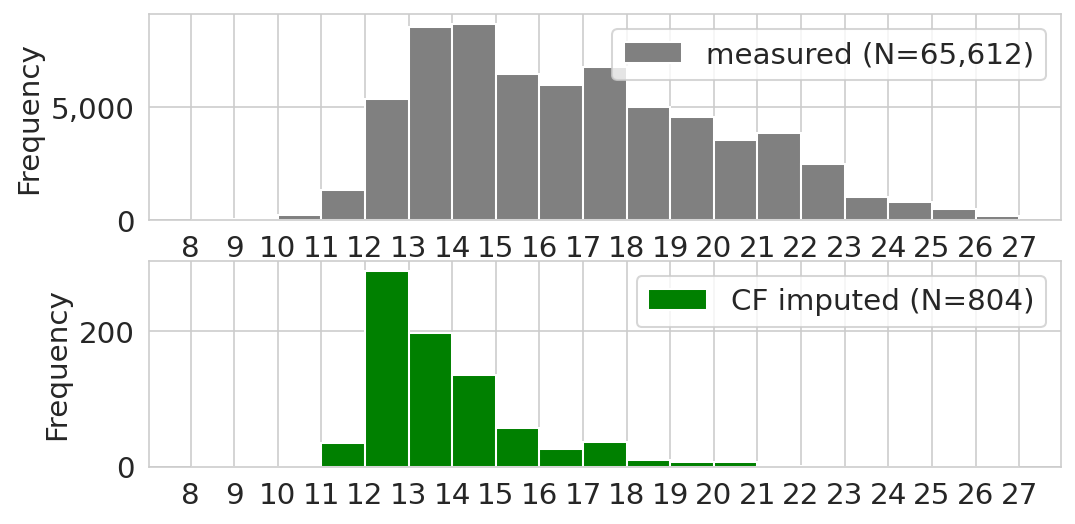

In [19]:
#check the difference with the OG dataframe
proteomes_imputed = proteomes_imputed.stack()
observed = proteomes_imputed.loc[proteomes_stack.index]
imputed = proteomes_imputed.loc[proteomes_imputed.index.difference(proteomes_stack.index)]
proteomes_imputed = proteomes_imputed.unstack()

assert len(proteomes_stack) == len(observed)
assert proteomes_imputed.shape[0] * proteomes_imputed.shape[1] == len(imputed) + len(observed)

fig, axes = plt.subplots(2, figsize=(8, 4))

#make a plot for the distributions
min_max = pimmslearn.plotting.data.get_min_max_iterable(
    [observed, imputed])

label_template = '{method} (N={n:,d})'

ax, _ = pimmslearn.plotting.data.plot_histogram_intensities(
    observed,
    ax=axes[0],
    min_max=min_max,
    label=label_template.format(method='measured', n=len(observed), ),
    color='grey',
    alpha=1)
_ = ax.legend()

ax, _ = pimmslearn.plotting.data.plot_histogram_intensities(
    imputed,
    ax=axes[1],
    min_max=min_max,
    label=label_template.format(method='CF imputed', n=len(imputed), ),
    color='green',
    alpha=1)
_ = ax.legend()

Most of the imputed values have intensities lower than the global mean, indicating that the CF model was successfull in predicting low intensities values

###Variational Autoencoder

  <font color='red'>**Disclaimer:** the VAE was not optimized, since the CF imputation performed much better from the beginning. Hence the following code is not optimized.</font>

In [20]:
splits.to_wide_format()

#check splits (use the same as CF imputation)
if splits.val_y is not None:
    splits.val_y = pd.DataFrame(pd.NA, index=splits.train_X.index,
                                columns=splits.train_X.columns).fillna(splits.val_y)

    print(splits.train_X.shape, splits.val_y.shape)

(112, 593) (112, 593)


In [21]:
from pimmslearn.sklearn.ae_transformer import AETransformer

model = AETransformer(
    model="VAE",
    hidden_layers=[512,],
    latent_dim=50,
    out_folder='runs/scikit_interface',
    batch_size=10,
)

epoch,train_loss,valid_loss,time
0,816.898804,51.766483,00:00
1,812.110168,53.485752,00:00
2,805.904114,54.026768,00:00
3,796.255310,56.262753,00:00
4,784.314697,60.478268,00:00
5,770.253174,64.253807,00:00
6,755.406128,67.974205,00:00
7,744.474976,76.909164,00:00
8,729.104309,79.888107,00:00
9,719.754883,80.154190,00:00


AETransformer(batch_size=10, hidden_layers=[512], latent_dim=50,
              model=<class 'pimmslearn.models.vae.VAE'>,
              out_folder=Path('runs/scikit_interface'))

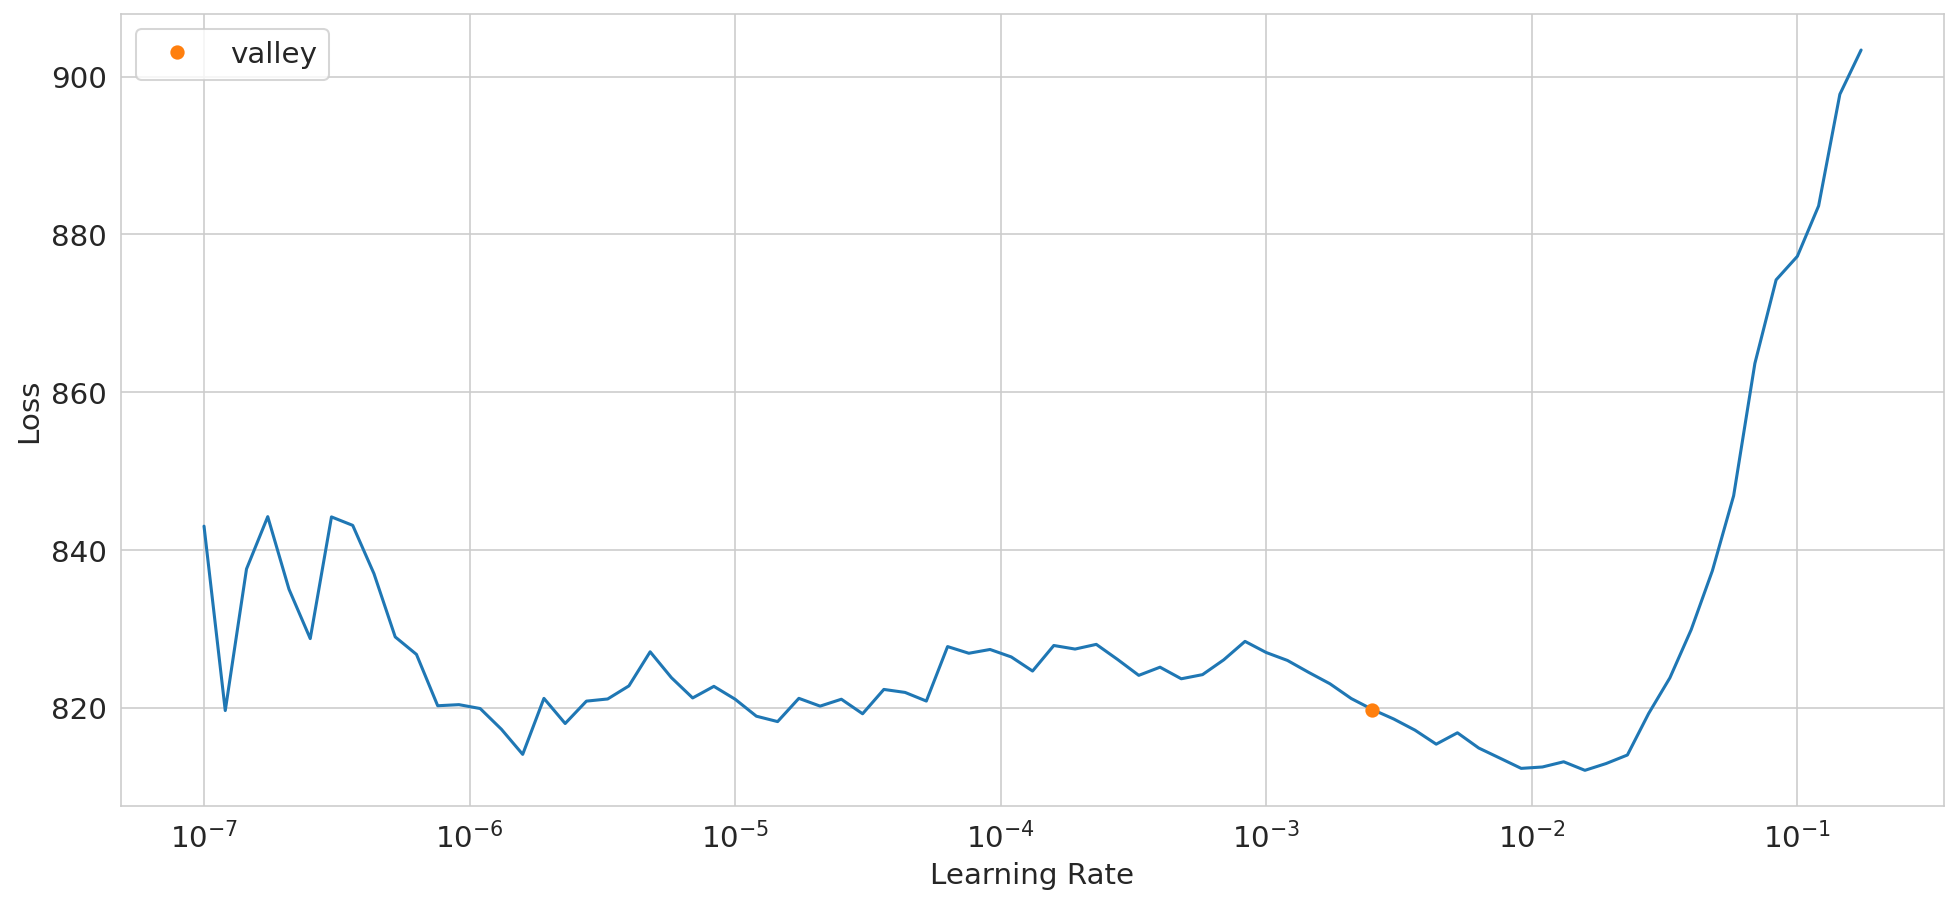

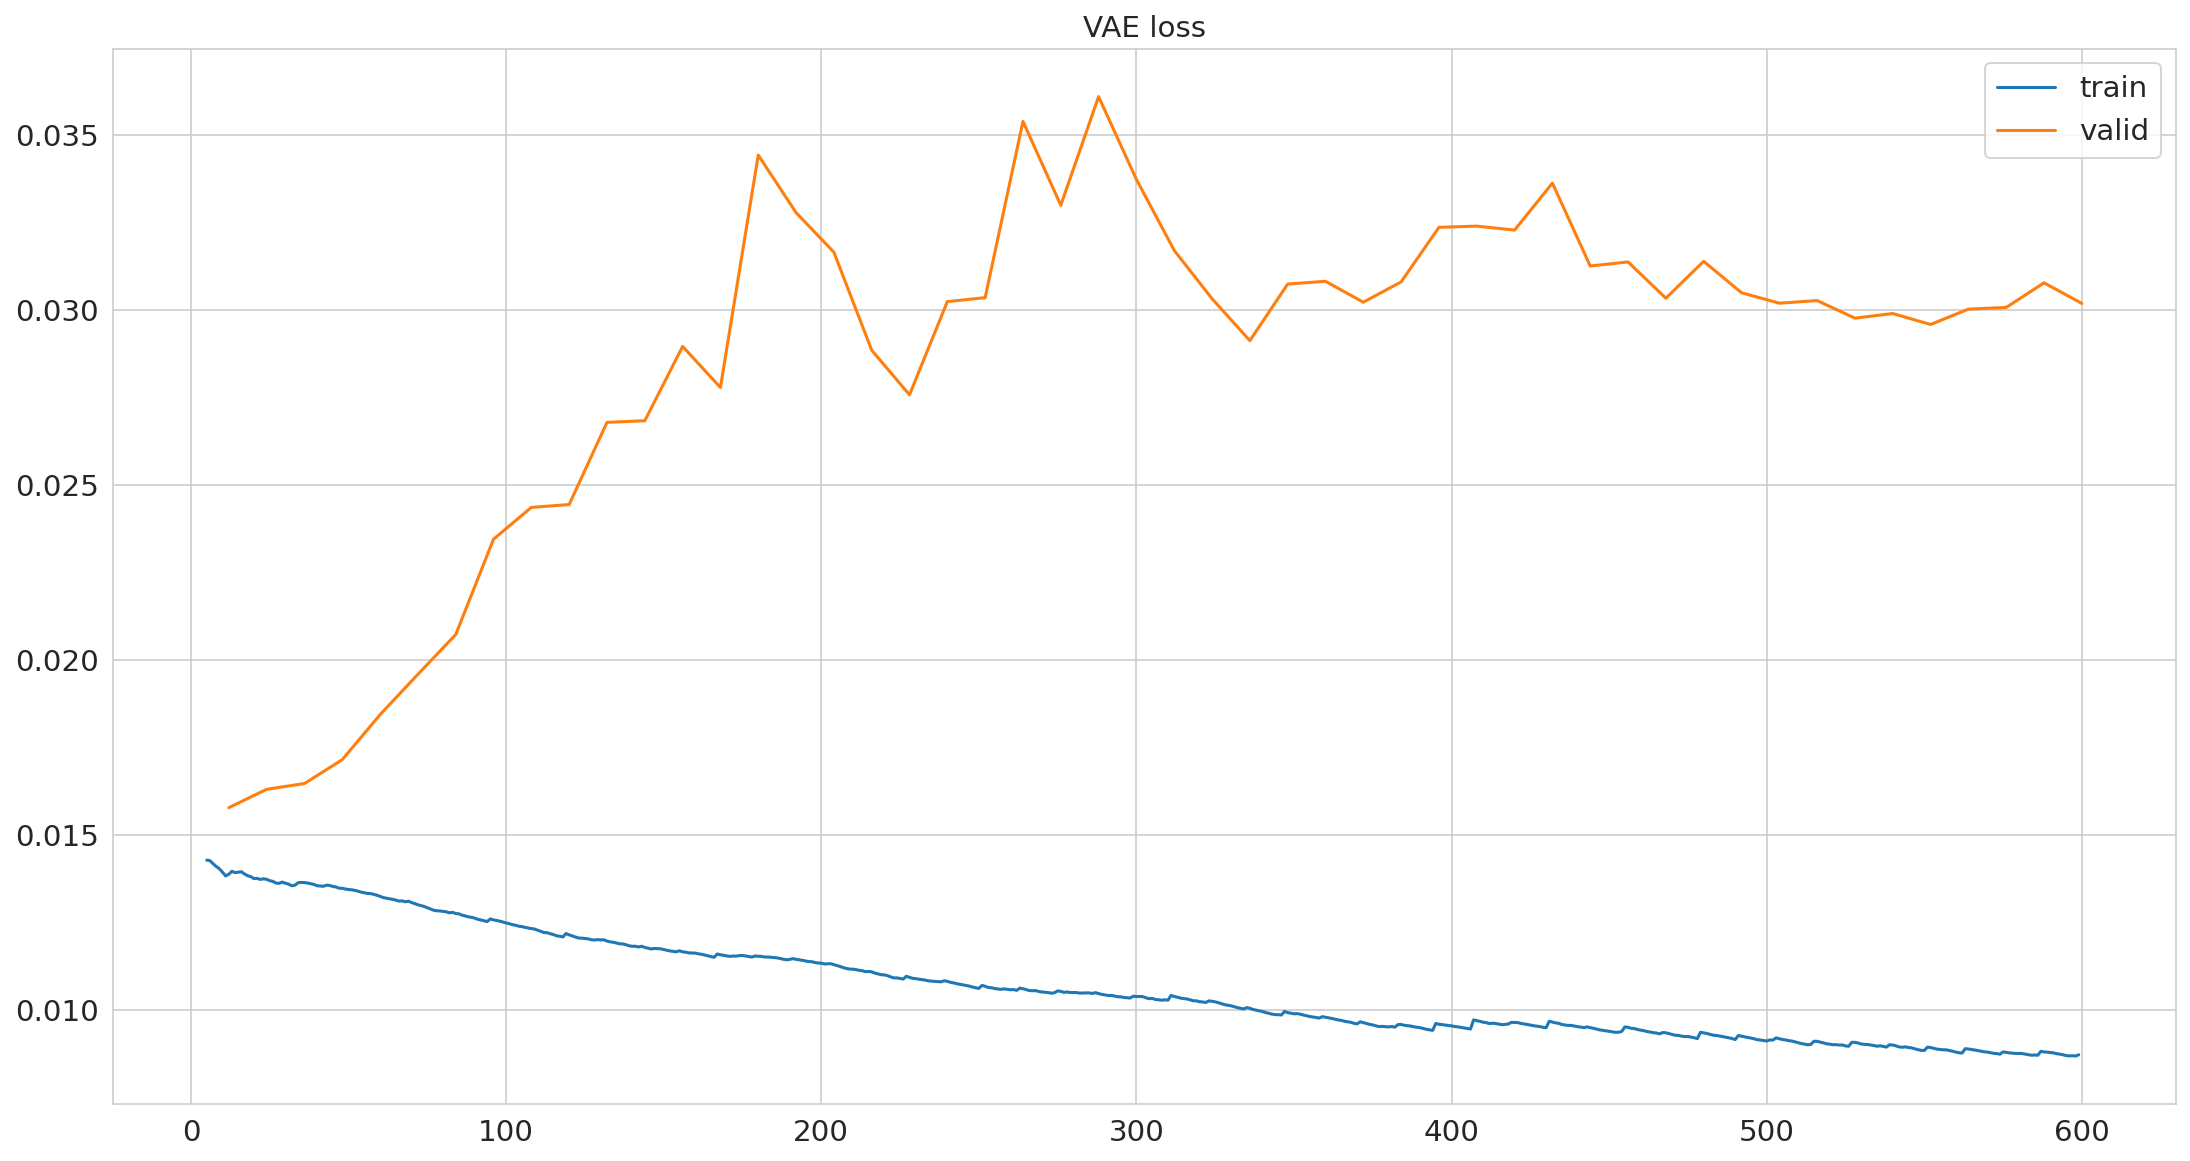

In [22]:
model.fit(splits.train_X, splits.val_y,
          epochs_max=50,
          cuda=False)

VL and TL do not converge so overfitting is likely. This model is very bad.

###Denoising Autoencoder

  <font color='red'>**Disclaimer:** the DAE was not optimized, since the CF imputation performed much better from the beginning. Hence the following code is not optimized.</font>

In [23]:
model = AETransformer(
    model="DAE",
    hidden_layers=[512,],
    latent_dim=50,
    out_folder='runs/scikit_interface',
    batch_size=10,
)

epoch,train_loss,valid_loss,time
0,5634.583984,370.716644,00:00
1,5492.168457,369.714600,00:00
2,5335.797852,362.146484,00:00
3,5116.275879,339.283508,00:00
4,4827.180664,309.624695,00:00
5,4530.530273,284.655304,00:00
6,4251.494629,272.563080,00:00
7,3965.945801,259.368256,00:00
8,3681.473633,250.007217,00:00
9,3420.474121,247.551270,00:00


AETransformer(batch_size=10, hidden_layers=[512], latent_dim=50,
              model=<class 'pimmslearn.models.ae.Autoencoder'>,
              out_folder=Path('runs/scikit_interface'))

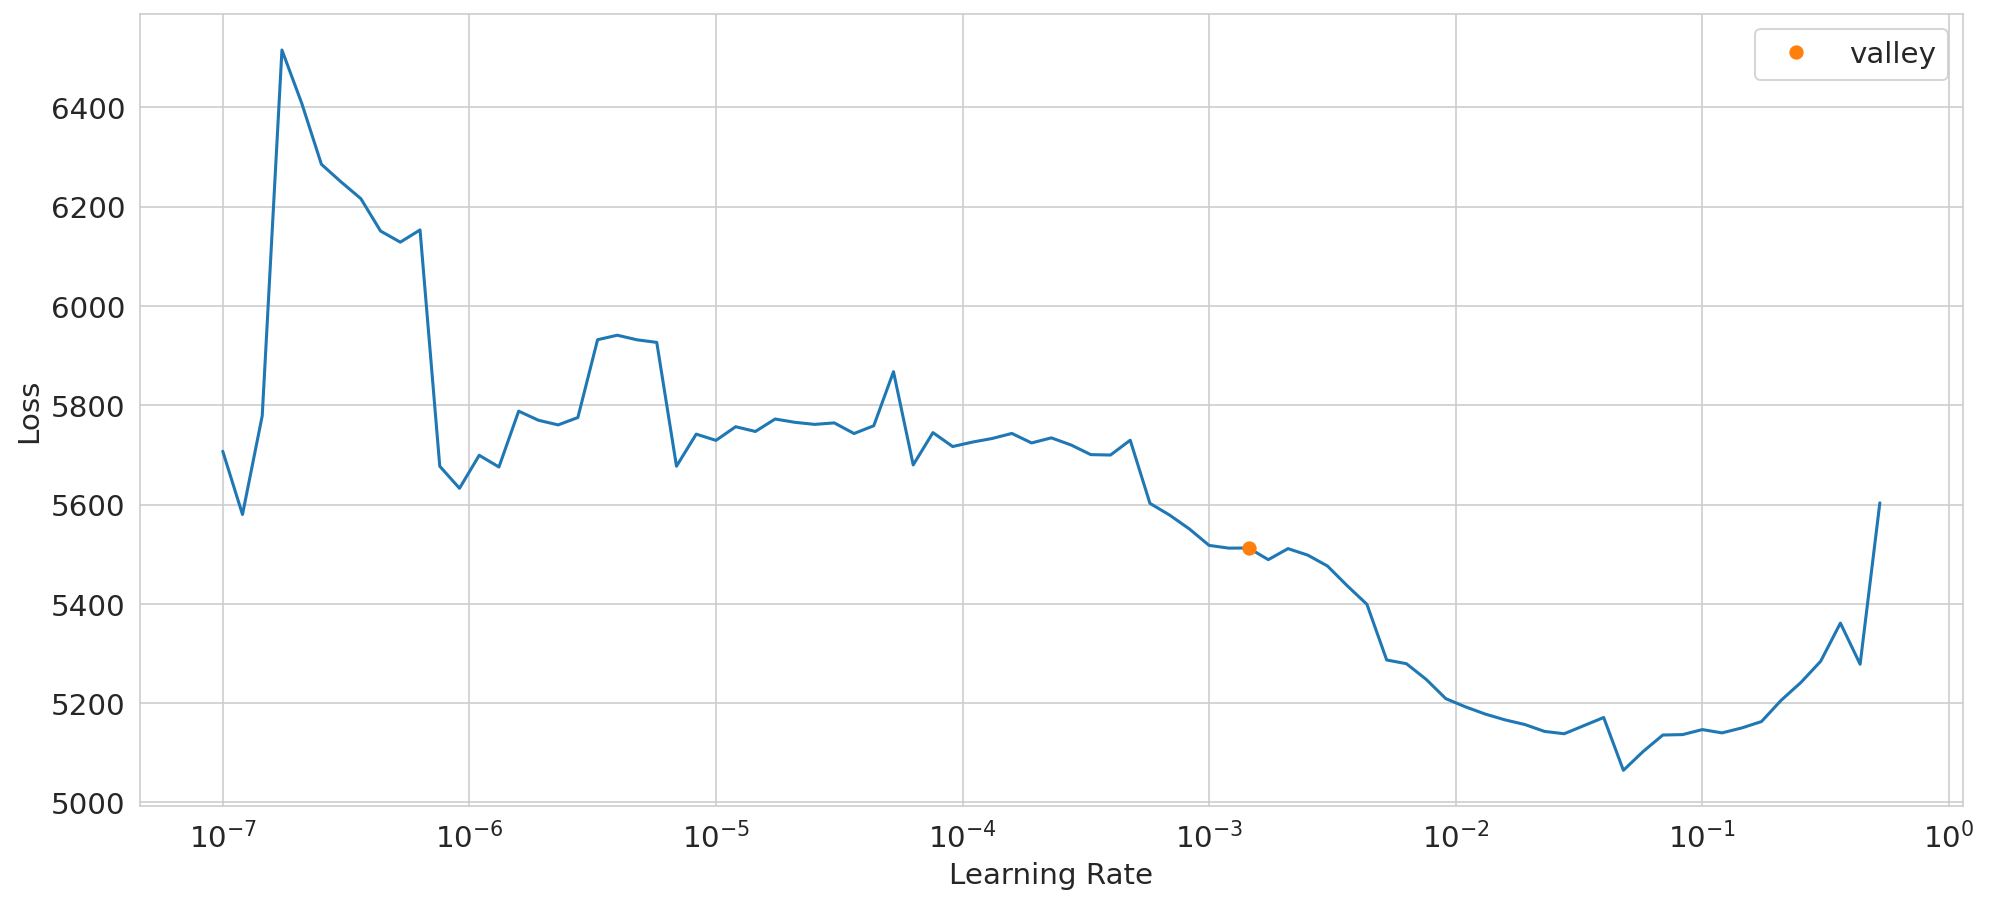

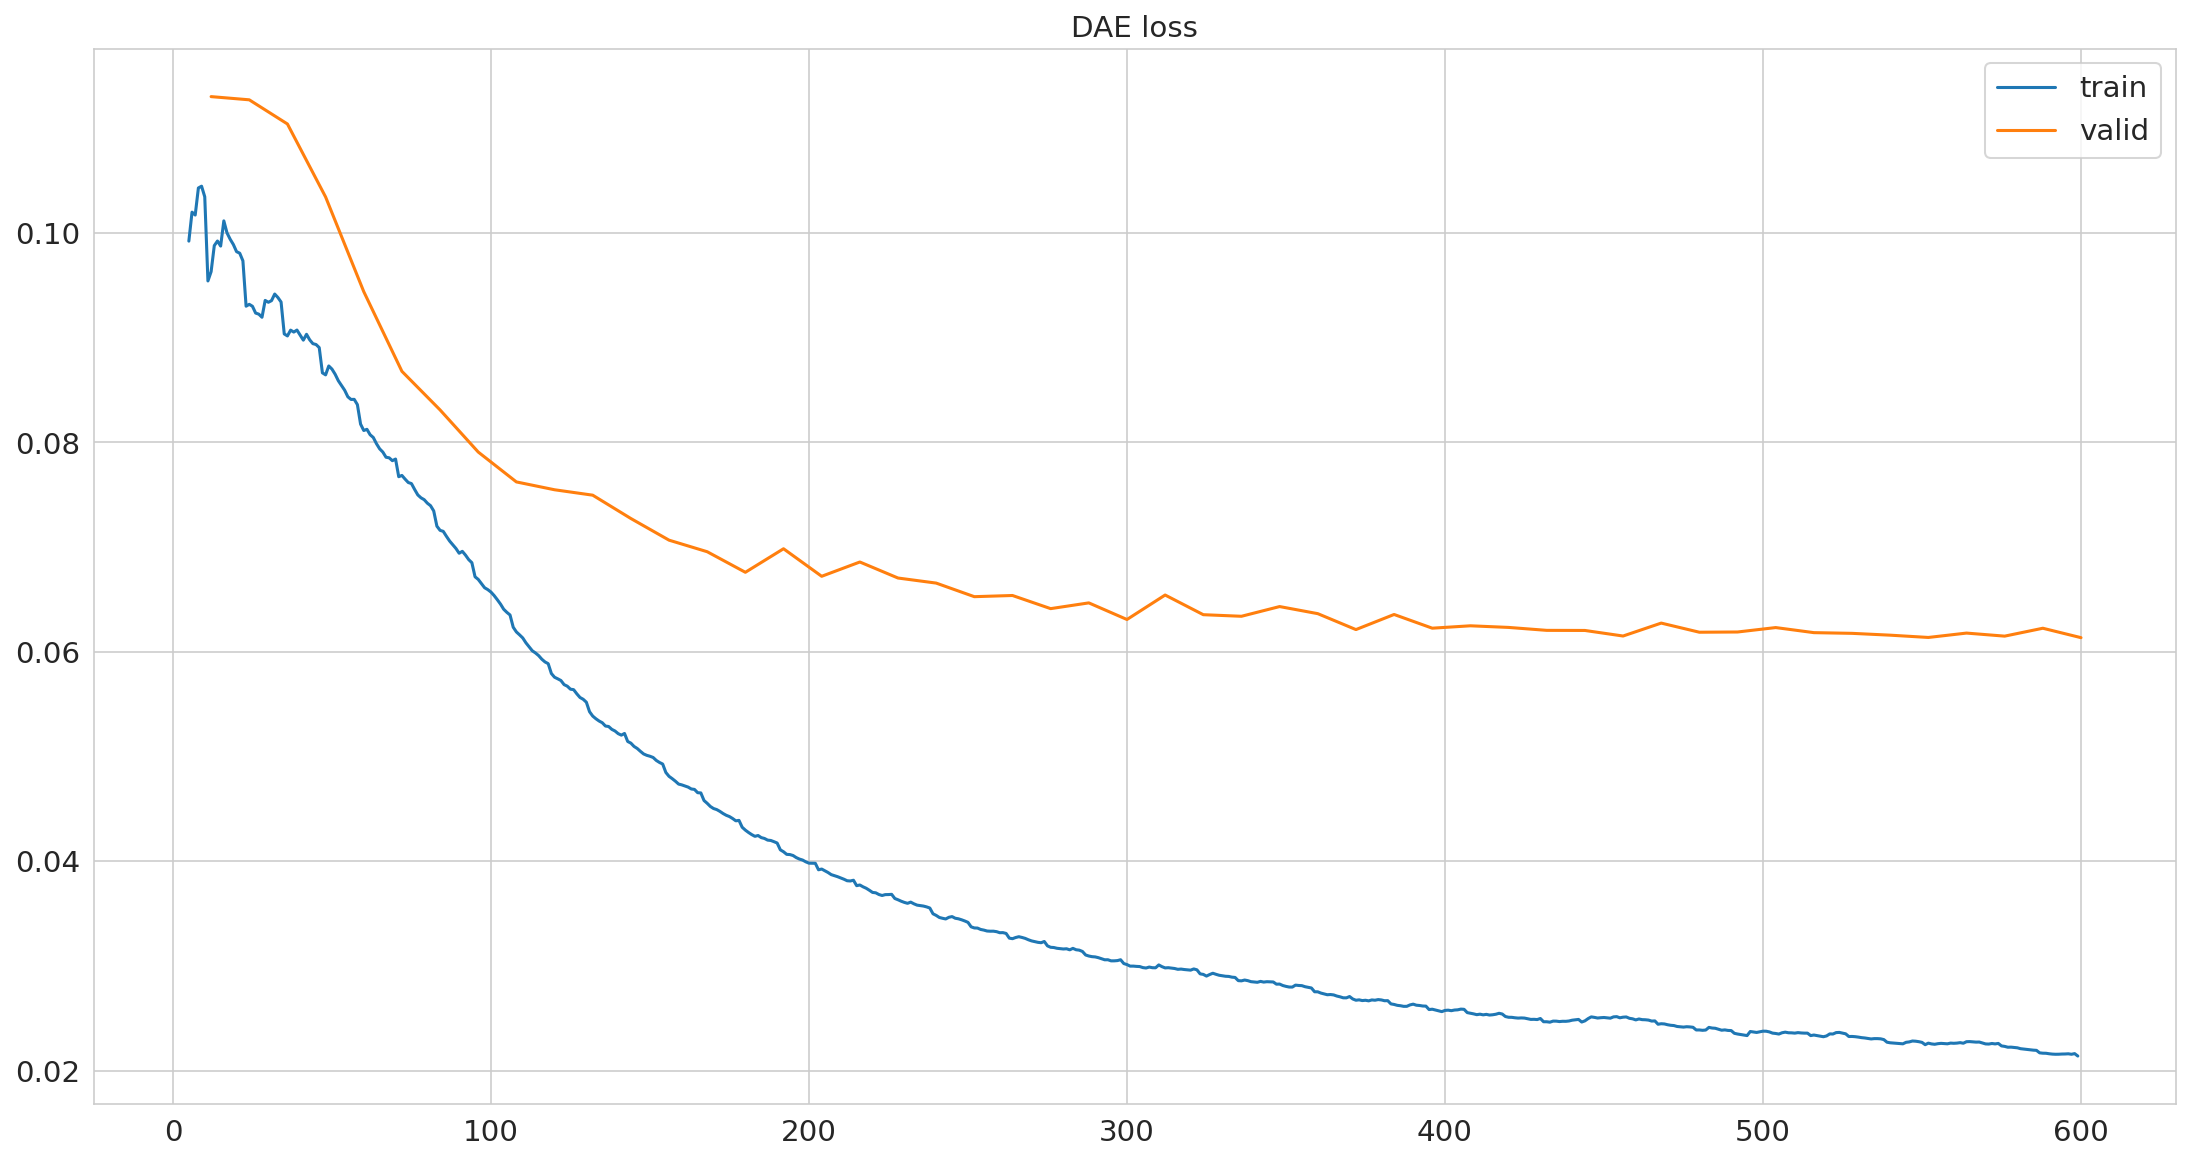

In [24]:
model.fit(splits.train_X, splits.val_y,
          epochs_max=50,
          cuda=False)

The validation loss stabilizes at around 200, which is even worse than it was for the VAE. This model is terrible.

##Normalization

Impute first to obtain a complete matrix, then normalize. This approach preserves the raw missingness pattern for imputation, allows normalization to be applied uniformly across the whole dataset, and matches the assumptions of most downstream statistical methods.

In [51]:
proteomes_imputed = pd.read_csv('/content/drive/My Drive/rhabdomyolysis/proteomes_imputed.csv', index_col=0)

In [52]:
#z score normalization
proteomes_impnorm = proteomes_imputed.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

#proteomes_impnorm.to_csv('/content/drive/My Drive/rhabdomyolysis/proteomes_impnorm.csv')
proteomes_impnorm

,A0A804HIW2;A0A067XG54,A0A075B6H7;A0A0C4DH90;A0A0C4DH55;P01624,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I9,A0A075B6J1,A0A075B6J9,A0A075B6K0,A0A075B6K2,...,Q9Y490,Q9Y4L1;A0A494C039;K7EQK2;A0A087X054,Q9Y5C1,Q9Y5F6-2,Q9Y5Y7,Q9Y646,Q9Y6R7;A0A087WXI2,Q9Y6Y1;H0YJR7;A0A8V8TQA4;A0A8V8TQX9;A0A8V8TR82;A0A8V8TR85;A0A8V8TPP2;A0A8V8TPQ2;A0A8V8TQ65;A0A8V8TQ84;A0A8V8TQ87;A0A8V8TQ98;Q9Y6Y1-2;A0A0C4DGL0,Q9Y6Z7,V9GYM3
Sample ID,,,,,,,,,,,,,,,,,,,,,
S1,0.837,-0.205,0.208,0.299,0.449,0.073,-0.524,0.387,0.799,-2.621,...,0.157,-0.418,-0.020,-0.223,-0.266,0.174,1.376,-0.646,0.708,0.966
S2,0.321,0.666,0.374,0.368,0.417,0.247,-0.246,0.187,0.429,-2.189,...,0.691,-0.369,-0.775,-0.007,-0.277,0.409,1.239,-0.112,0.504,1.810
S3,1.329,-0.923,-0.003,-0.013,0.153,-0.538,-0.883,0.020,0.353,0.153,...,-1.340,-1.820,0.436,-0.590,-0.053,1.407,1.546,0.798,-0.846,1.488
S4,1.341,0.057,-0.474,-0.302,0.305,-0.697,-0.485,-0.084,0.070,-1.126,...,-0.397,-0.061,0.571,-0.464,-0.927,0.234,1.826,0.097,0.959,2.146
S6,1.910,0.937,-0.222,-0.356,-2.636,-0.074,-0.792,-0.283,0.074,-1.352,...,1.206,-0.922,0.353,-1.007,-1.117,-0.425,1.582,0.174,0.824,1.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S142,-0.063,-0.108,0.505,1.239,0.096,0.583,0.303,-0.677,0.986,0.988,...,0.201,0.447,0.324,0.996,0.627,0.798,0.169,0.286,0.879,-1.483
S143,-1.380,-0.102,-0.056,1.624,0.352,0.767,0.388,-0.605,0.401,0.740,...,2.711,1.210,-1.254,0.906,0.523,1.021,-0.524,-0.192,0.318,-0.371
S146,-0.705,-0.487,-0.426,0.676,-0.974,0.734,-1.068,-1.483,0.226,0.503,...,0.300,0.669,-0.602,-0.369,0.179,0.948,-0.592,-0.057,-3.106,-2.810


##Outlier detection

Performing a quick PCA and plotting PC1 and PC2 can show if there are observation that greatly differ from all the others.

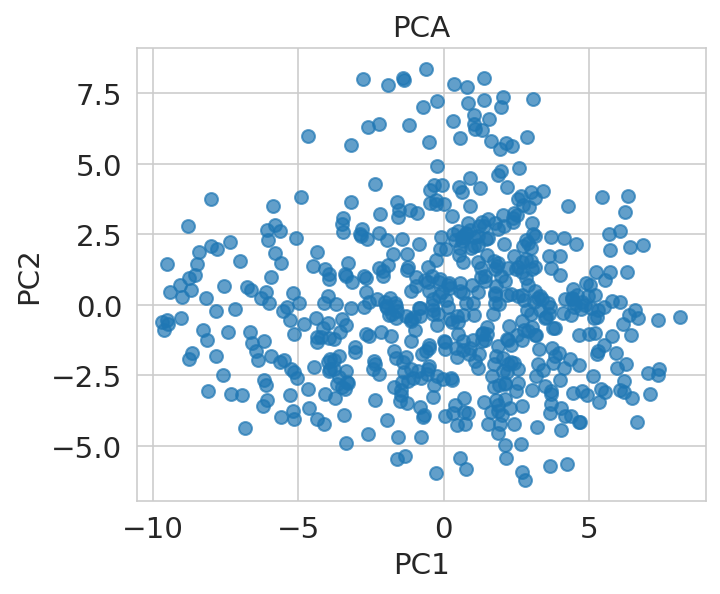

In [53]:
from sklearn.decomposition import PCA

data = proteomes_impnorm.T

#PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

plt.figure(figsize=(5,4))
plt.scatter(X_pca[:,0], X_pca[:,1], s=40, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA')
plt.show()


Observation with a mean intensity much higher/lower than all the others are likely outliers.

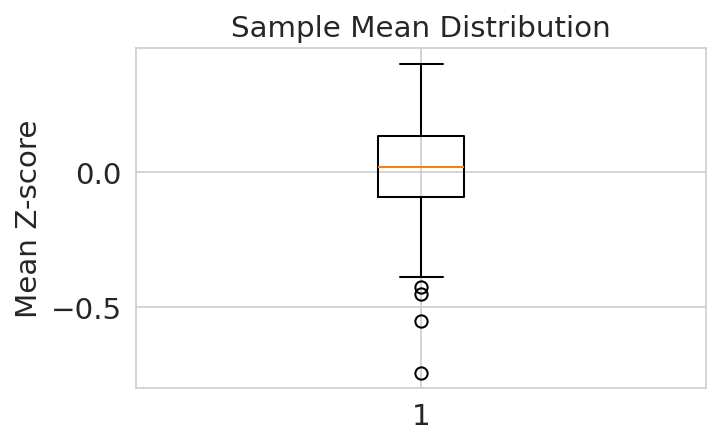

In [54]:
sample_means = proteomes_impnorm.mean(axis=1)
plt.figure(figsize=(5,3))
plt.boxplot(sample_means)
plt.title('Sample Mean Distribution')
plt.ylabel('Mean Z-score')
plt.show()


In [55]:
#find outlier samples
z_scores = (sample_means - sample_means.mean()) / sample_means.std()
outlier_samples = proteomes_impnorm.index[np.abs(z_scores) > 3]
print("Outliers:", outlier_samples.tolist())


Outliers: ['S46']


In [56]:
#remove sample detected as outlier
proteomes_impnorm_noout = proteomes_impnorm.drop(index=outlier_samples, errors="ignore")

proteomes_impnorm_noout.to_csv('/content/drive/My Drive/rhabdomyolysis/proteomes_impnorm_noout.csv')

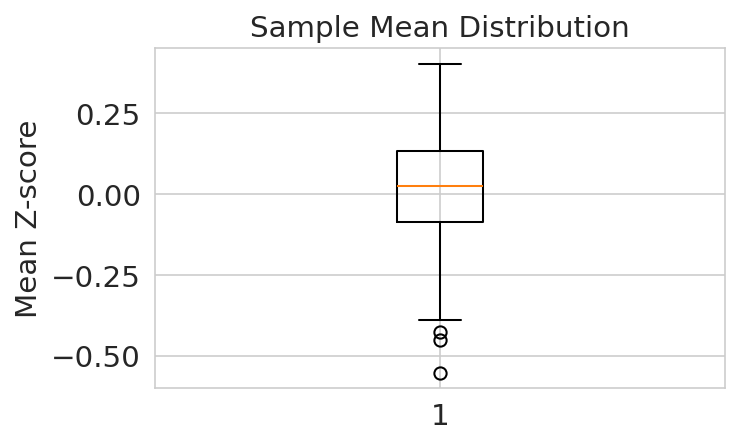

In [57]:
#replot means intensities per sample
sample_means = proteomes_impnorm_noout.mean(axis=1)
plt.figure(figsize=(5,3))
plt.boxplot(sample_means)
plt.title('Sample Mean Distribution')
plt.ylabel('Mean Z-score')
plt.show()


#Exploratory Data Analysis

In [100]:
#reload previously saved dataframe if needed
proteomes_impnorm_noout = pd.read_csv('/content/drive/My Drive/rhabdomyolysis/proteomes_impnorm_noout.csv', index_col=0)

In [102]:
#prepare the metadata table
meta = meta.loc[:, ~meta.columns.str.contains('^Unnamed')]
meta = meta.set_index('sample')
meta = meta.loc[meta.index.intersection(proteomes_impnorm_noout.index)]
meta

KeyError: "None of ['sample'] are in the columns"

In [103]:
meta.to_csv('/content/drive/My Drive/rhabdomyolysis/meta.csv')

Subject centering removes all effects caused by difference between subjects. The `treatment` variable is nested within `subject` so this should be used with caution, but it can be useful to study which features/PCs show a correlation to other variables after removing the variance attributed to subject/treatment.

<font color='red'>**Do not run the following cell unless you wish to perform subject centering**</font>

In [64]:
meta_subjects = meta.loc[proteomes_impnorm_noout.index, 'subject']

def subject_centering(df, meta_subjects):
    df_centered = df.copy()
    for subject in meta_subjects.unique():
        idx = meta_subjects[meta_subjects == subject].index
        #subtract mean across samples for this subject
        df_centered.loc[idx] = df.loc[idx] - df.loc[idx].mean(axis=0)
    return df_centered

proteomes_impnorm_noout = subject_centering(proteomes_impnorm_noout, meta_subjects)

##PCA

PCA can help identifying the main contributors to the variance in our dataset. By playing around with pre and post subject centering data, it is also possible to see what variables are affected by it and what variables are not.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from scipy.stats import spearmanr
from scipy.stats import kruskal
from sklearn.decomposition import PCA
from matplotlib_venn import venn2, venn3, venn3_circles, venn2_circles

###Scree Plot

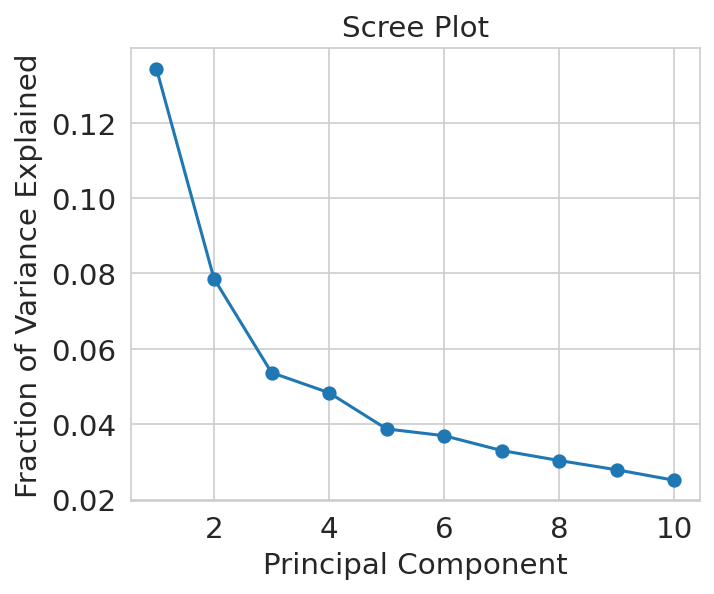

In [68]:
#scree plot to analyze the variance explained
pca = PCA(n_components=10)
pcs = pca.fit_transform(proteomes_impnorm_noout)

plt.figure(figsize=(5,4))
plt.plot(range(1, 11), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Fraction of Variance Explained')
plt.title('Scree Plot')
plt.show()


In [69]:
explained = pca.explained_variance_ratio_
cumulative = explained.cumsum()

print(f"Explained variance by component: {explained}")
print(f"Cumulative explained variance: {cumulative}")


Explained variance by component: [0.13434441 0.07865553 0.05369487 0.04834656 0.03874924 0.03694385
 0.033016   0.03036054 0.02790142 0.02512334]
Cumulative explained variance: [0.13434441 0.21299995 0.26669481 0.31504138 0.35379062 0.39073447
 0.42375047 0.45411101 0.48201244 0.50713577]


The following are the fractions of variance explained for the first 10 components


```
0.13434441, 0.07865553, 0.05369487, 0.04834656, 0.03874924, 0.03694384, 0.03301578, 0.03036219, 0.02790037, 0.02512283
```

The first 3 PCs capture 26.6% of the total variance. The gradual decrease in explained variance after the first 3 components suggests that the underlying structure of the dataset is moderately complex, and no single component or small subset of components dominates the total variance.

There isn't a clear elbow in the curve, and the top 9 PCs are required to obtain a cumulative explained variance > 50%.

After subject centering this changes to



```
0.13052804, 0.09312776, 0.06349714, 0.04877753, 0.04765353,0.03616232, 0.03255   , 0.02706642, 0.02470868, 0.01865599
```



###PCA and metadata

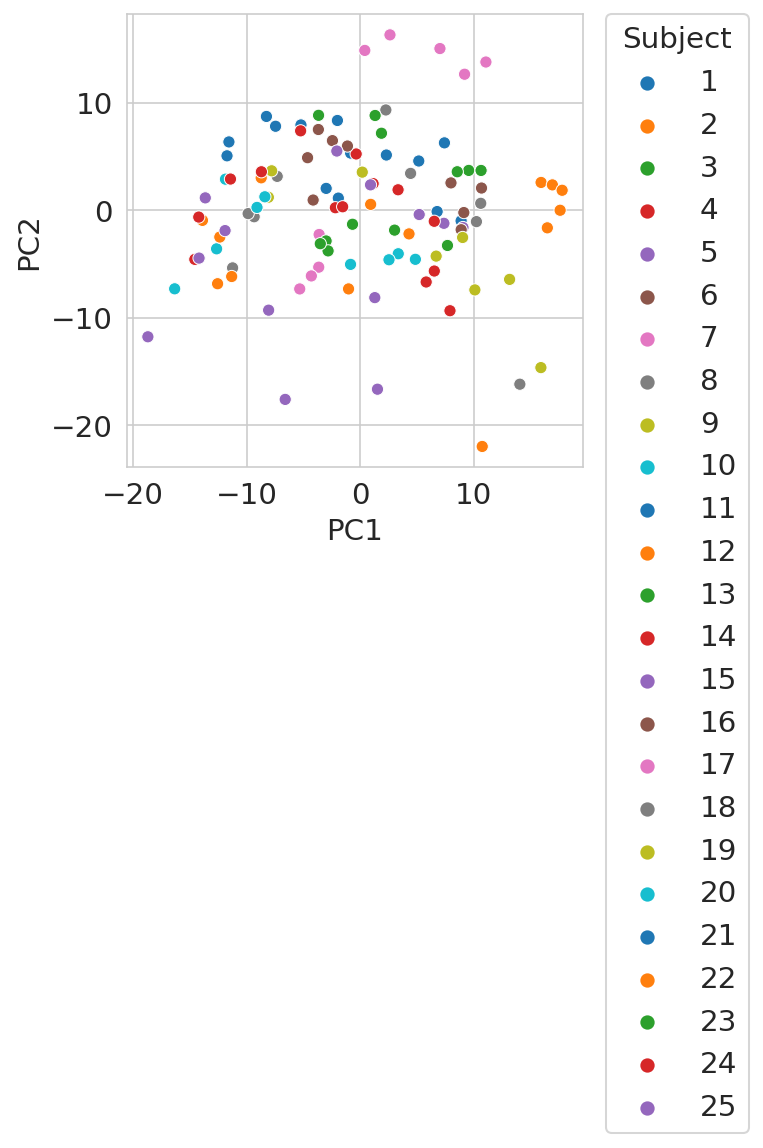

In [70]:
#change components and coloring to study correlations
pca_df = pd.DataFrame(pcs[:, :2], index=proteomes_impnorm_noout.index, columns=['PC1', 'PC2']) #principal components
pca_df = pca_df.join(meta[['subject']]) #change column from metadata

plt.figure(figsize=(4,4))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='subject', palette='tab10') #change here too
plt.legend(
    title='Subject', #here too!
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)
plt.show()


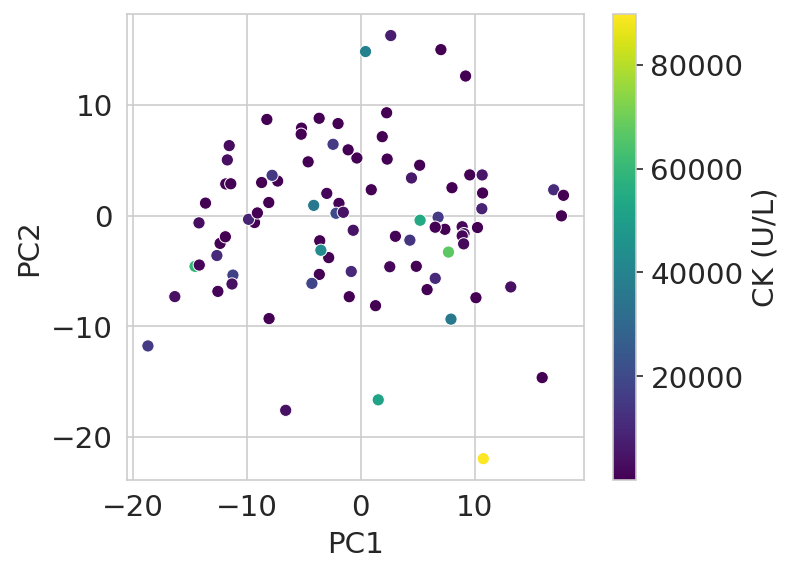

In [71]:
#same but for continuous variables
pca_df = pd.DataFrame(pcs[:, :2], index=proteomes_impnorm_noout.index, columns=['PC1', 'PC2']) #principal components
pca_df = pca_df.join(meta[['CK (U/L)']]) #column from metadata
pca_df['CK (U/L)'] = pd.to_numeric(pca_df['CK (U/L)'], errors='coerce')

plt.figure(figsize=(5.45,4)) #5.45 for ck
scatter = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='CK (U/L)', palette='viridis', legend=False)
norm = plt.Normalize(pca_df['CK (U/L)'].min(), pca_df['CK (U/L)'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=scatter)
cbar.set_label('CK (U/L)')

plt.tight_layout()
plt.show()

In [72]:
#correlation between PCs and metadata variables
pca_df = pd.DataFrame(pcs[:, :10], index=proteomes_impnorm_noout.index, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']) #principal components
pca_df = pca_df.join(meta[['subject', 'visit', 'treatment', 'dystrophy (%)', 'CK (U/L)']])

pca_df['dystrophy (%)'] = pd.to_numeric(pca_df['dystrophy (%)'], errors='coerce')
pca_df['CK (U/L)'] = pd.to_numeric(pca_df['CK (U/L)'], errors='coerce')

In [73]:
#correlate PCs to continuous variables
continuous_vars = ['dystrophy (%)', 'CK (U/L)']
pc_axes = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']

results_cont = []
for axis in pc_axes:
    for var in continuous_vars:
        mask = pca_df[[axis, var]].dropna()
        if mask.shape[0] > 0:
            corr, pval = spearmanr(mask[axis], mask[var])
            results_cont.append({'PC': axis, 'Variable': var, 'Spearman rho': corr, 'p-value': pval})

cont_corr_df = pd.DataFrame(results_cont)
print(cont_corr_df)



      PC       Variable  Spearman rho  p-value
0    PC1  dystrophy (%)        -0.059    0.793
1    PC1       CK (U/L)        -0.001    0.995
2    PC2  dystrophy (%)        -0.099    0.661
3    PC2       CK (U/L)        -0.240    0.024
4    PC3  dystrophy (%)        -0.197    0.381
5    PC3       CK (U/L)         0.119    0.270
6    PC4  dystrophy (%)        -0.180    0.422
7    PC4       CK (U/L)         0.052    0.629
8    PC5  dystrophy (%)         0.017    0.940
9    PC5       CK (U/L)        -0.426    0.000
10   PC6  dystrophy (%)        -0.020    0.928
11   PC6       CK (U/L)        -0.071    0.510
12   PC7  dystrophy (%)         0.177    0.430
13   PC7       CK (U/L)         0.026    0.809
14   PC8  dystrophy (%)        -0.549    0.008
15   PC8       CK (U/L)        -0.314    0.003
16   PC9  dystrophy (%)         0.275    0.216
17   PC9       CK (U/L)        -0.382    0.000
18  PC10  dystrophy (%)        -0.031    0.893
19  PC10       CK (U/L)         0.126    0.242


```
      PC       Variable  Spearman rho   p-value
0    PC1  dystrophy (%)     -0.059474  0.792624
1    PC1       CK (U/L)     -0.000687  0.994933
2    PC2  dystrophy (%)     -0.099123  0.660755
3    PC2       CK (U/L)     -0.240117  0.024236 *
4    PC3  dystrophy (%)     -0.196546  0.380668
5    PC3       CK (U/L)      0.118896  0.269891
6    PC4  dystrophy (%)     -0.180120  0.422487
7    PC4       CK (U/L)      0.052262  0.628680
8    PC5  dystrophy (%)      0.016992  0.940171
9    PC5       CK (U/L)     -0.426483  0.000034 *
10   PC6  dystrophy (%)     -0.020391  0.928233
11   PC6       CK (U/L)     -0.070851  0.511845
12   PC7  dystrophy (%)      0.177288  0.429939
13   PC7       CK (U/L)      0.024181  0.823049
14   PC8  dystrophy (%)     -0.557918  0.006973 °
15   PC8       CK (U/L)     -0.316155  0.002693 *
16   PC9  dystrophy (%)      0.274711  0.215987
17   PC9       CK (U/L)     -0.383862  0.000223 *
18  PC10  dystrophy (%)     -0.030586  0.892517
19  PC10       CK (U/L)      0.125148  0.245325
```

Somewhat ok results. PC2, PC5, PC8 and PC9 correlate with `CK`, while only PC 8 correlates with `dystrophy`.

After normalizing the dataset by `subject`, these are the new results:



```
      PC       Variable  Spearman rho       p-value
0    PC1  dystrophy (%)      0.245257  2.712796e-01
1    PC1       CK (U/L)     -0.188541  7.854411e-02
2    PC2  dystrophy (%)     -0.122346  5.875435e-01
3    PC2       CK (U/L)      0.717805  3.551376e-15 *
4    PC3  dystrophy (%)     -0.121213  5.910332e-01
5    PC3       CK (U/L)      0.050950  6.373342e-01
6    PC4  dystrophy (%)     -0.154631  4.920205e-01
7    PC4       CK (U/L)     -0.252797  1.748853e-02 *
8    PC5  dystrophy (%)     -0.468425  2.789276e-02 °
9    PC5       CK (U/L)      0.026594  8.057242e-01
10   PC6  dystrophy (%)     -0.244691  2.724232e-01
11   PC6       CK (U/L)      0.143473  1.823474e-01
12   PC7  dystrophy (%)      0.113283  6.157033e-01
13   PC7       CK (U/L)     -0.163982  1.268497e-01
14   PC8  dystrophy (%)     -0.135373  5.480611e-01
15   PC8       CK (U/L)     -0.110451  3.056240e-01
16   PC9  dystrophy (%)     -0.184651  4.107101e-01
17   PC9       CK (U/L)      0.243516  2.223972e-02 *
18  PC10  dystrophy (%)     -0.372701  8.758874e-02
19  PC10       CK (U/L)     -0.106999  3.210792e-01
```

PC2, PC4 and PC9 seem to be correlated with `CK`, while PC5 seems correlated with `dystrophy`. This suggests that analysis on these two variables could be carried out on both the pre and post subject centering dataset.

In [74]:
#correlation between categorical variables and PCs
cat_vars = ['subject', 'visit', 'treatment']
results_cat = []

for axis in pc_axes:
    for var in cat_vars:
        groups = [pca_df[pca_df[var] == v][axis].dropna() for v in pca_df[var].unique() if pd.notnull(v)]
        if len(groups) > 1:
            stat, pval = kruskal(*groups)
            results_cat.append({'PC': axis, 'Variable': var, 'Kruskal-Wallis H': stat, 'p-value': pval})

cat_corr_df = pd.DataFrame(results_cat)
print(cat_corr_df)

      PC   Variable  Kruskal-Wallis H  p-value
0    PC1    subject            88.293    0.000
1    PC1      visit             1.079    0.898
2    PC1  treatment             8.342    0.004
3    PC2    subject            73.390    0.000
4    PC2      visit            12.981    0.011
5    PC2  treatment             3.162    0.075
6    PC3    subject            81.336    0.000
7    PC3      visit             6.552    0.162
8    PC3  treatment            11.386    0.001
9    PC4    subject            82.571    0.000
10   PC4      visit             1.141    0.888
11   PC4  treatment             9.603    0.002
12   PC5    subject            80.287    0.000
13   PC5      visit            18.242    0.001
14   PC5  treatment             3.988    0.046
15   PC6    subject            98.193    0.000
16   PC6      visit             1.303    0.861
17   PC6  treatment            10.371    0.001
18   PC7    subject            84.202    0.000
19   PC7      visit             3.803    0.433
20   PC7  tre

```
      PC   Variable  Kruskal-Wallis H       p-value
0    PC1    subject         88.293147  2.757625e-09 °
1    PC1      visit          1.079412  8.975247e-01
2    PC1  treatment          8.342169  3.873533e-03 #
3    PC2    subject         73.389994  6.627265e-07 °
4    PC2      visit         12.980587  1.137104e-02 *
5    PC2  treatment          3.162489  7.534824e-02
6    PC3    subject         81.375820  3.667381e-08 °
7    PC3      visit          6.542487  1.621329e-01
8    PC3  treatment         11.386492  7.398013e-04 #
9    PC4    subject         82.557819  2.368447e-08 °
10   PC4      visit          1.154233  8.855749e-01
11   PC4  treatment          9.603351  1.942226e-03 #
12   PC5    subject         80.286728  5.476375e-08 °
13   PC5      visit         18.241689  1.106839e-03 *
14   PC5  treatment          3.988355  4.581578e-02 #
15   PC6    subject         98.192745  6.098030e-11 °
16   PC6      visit          1.298358  8.616540e-01
17   PC6  treatment         10.423572  1.244170e-03 #
18   PC7    subject         84.179488  1.295556e-08 °
19   PC7      visit          3.856556  4.257668e-01
20   PC7  treatment          0.435989  5.090650e-01
21   PC8    subject         88.723488  2.342429e-09 °
22   PC8      visit          8.094279  8.818504e-02
23   PC8  treatment          4.086025  4.323922e-02 #
24   PC9    subject         79.323311  7.795707e-08 °
25   PC9      visit         19.583980  6.032457e-04 *
26   PC9  treatment          0.073663  7.860762e-01
27  PC10    subject         96.462629  1.196939e-10 °
28  PC10      visit          1.213989  8.757900e-01
29  PC10  treatment          3.220382  7.272666e-02
```

This looks good. As expected, the strongest correlation and significance is with the variable `subject`, indicating that most variance is caused simply by differences between subjects.

PC1, PC3, PC4 and PC5 seem particolarly correlated with `treatment`.
PC2 and PC5 seem correlated with `CK` and `visit` (check covariance).

The new results after normalizing by subject:

```
      PC   Variable  Kruskal-Wallis H       p-value
0    PC1    subject         12.054858  9.792830e-01
1    PC1      visit         16.281590  2.663677e-03 *
2    PC1  treatment          0.001329  9.709172e-01
3    PC2    subject          1.827301  1.000000e+00
4    PC2      visit         66.694194  1.130915e-13 *
5    PC2  treatment          0.129981  7.184517e-01
6    PC3    subject          1.706306  1.000000e+00
7    PC3      visit         30.750043  3.442667e-06 *
8    PC3  treatment          0.830740  3.620587e-01
9    PC4    subject          2.402606  1.000000e+00
10   PC4      visit         13.586761  8.737722e-03 *
11   PC4  treatment          0.689617  4.062949e-01
12   PC5    subject          2.383253  1.000000e+00
13   PC5      visit         35.411897  3.822822e-07 *
14   PC5  treatment          0.000148  9.903038e-01
15   PC6    subject          2.341441  1.000000e+00
16   PC6      visit         10.951210  2.711786e-02 *
17   PC6  treatment          0.256401  6.126035e-01
18   PC7    subject          4.367889  9.999967e-01
19   PC7      visit          6.629321  1.568223e-01
20   PC7  treatment          3.076633  7.942478e-02
21   PC8    subject          2.165975  1.000000e+00
22   PC8      visit         27.641316  1.474456e-05 *
23   PC8  treatment          0.007237  9.322069e-01
24   PC9    subject          1.815734  1.000000e+00
25   PC9      visit         19.000654  7.857116e-04 *
26   PC9  treatment          0.217018  6.413216e-01
27  PC10    subject          4.832770  9.999910e-01
28  PC10      visit          8.672662  6.982293e-02
29  PC10  treatment          0.290271  5.900471e-01
```

PC1, PC2, PC3, PC4, PC5, PC6, PC8 and PC9 all seem correlated with `visit`. There is no more correlation to `treatment`, indicating that before subject centering this correlation was likely caused by variance between



###Extract Loadings

Principal components are not features from our collected data, they are linear combinations of the original variables. We can extract the features that contribute the most to each PC to have a first overview of what proteins **might** be affecting outcomes.

In [75]:
proteins = proteomes_impnorm_noout.columns
pcs_of_interest = list(range(10)) #can change depending on how many and which PCs we want

top_proteins_by_pc = {}
dfs = []

for pc_idx in pcs_of_interest:
    loadings = pca.components_.T[:, pc_idx]
    loading_df = pd.DataFrame({
        'loading': loadings,
        'abs_loading': np.abs(loadings)
    }, index=proteins).sort_values('abs_loading', ascending=False)

    n_top = int(0.05 * len(loading_df))  #only keep top 5%
    top_proteins = loading_df.head(n_top)
    top_proteins_by_pc[f'PC{pc_idx+1}'] = top_proteins

    loading_df['PC'] = f'PC{pc_idx+1}'
    loading_df['protein'] = loading_df.index
    dfs.append(loading_df)

all_loadings = pd.concat(dfs, axis=0, ignore_index=True)

In [ ]:
#save dataframe
all_loadings.to_csv('/content/drive/My Drive/rhabdomyolysis/loadings_sc.csv', index=False)

We can then analyze the intersection of top contributors to PCs correlated to a variable of choice (eg. `treatment`) and see if one or more proteins stand out

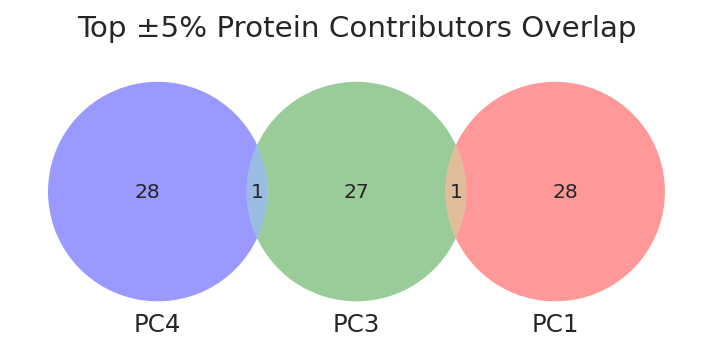

Proteins in top ±5% for all three PCs (PC1, PC3, PC4):
[]


In [76]:
#venn diagram example with PC1, PC3 and PC4 (all correlated to treatment)
sets = [set(top_proteins_by_pc['PC1'].index), set(top_proteins_by_pc['PC3'].index), set(top_proteins_by_pc['PC4'].index)]
plt.figure(figsize=(6,4))
venn3(sets, set_labels=('PC1', 'PC3', 'PC4'))
plt.title('Top ±5% Protein Contributors Overlap')
plt.show()

overlap_pcs = set(top_proteins_by_pc['PC1'].index) & set(top_proteins_by_pc['PC3'].index) & set(top_proteins_by_pc['PC4'].index)
print(f"Proteins in top ±5% for all three PCs (PC1, PC3, PC4):")
print(list(overlap_pcs))


No overlaps for any of the group of PCs

###Visualization

Let's visualize the PC trajectories over multiple visits, colored by treatment, and see if they show a difference between treatment groups.

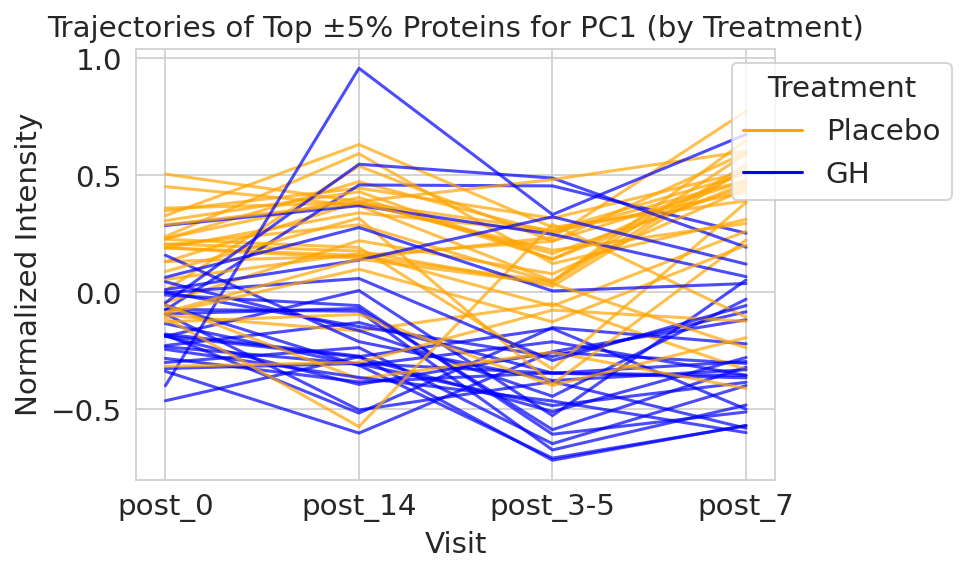

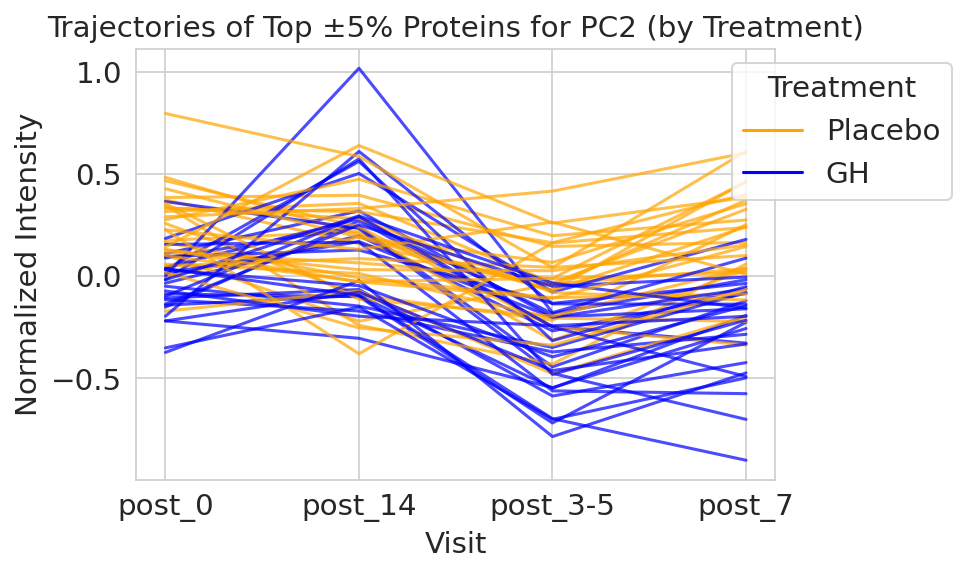

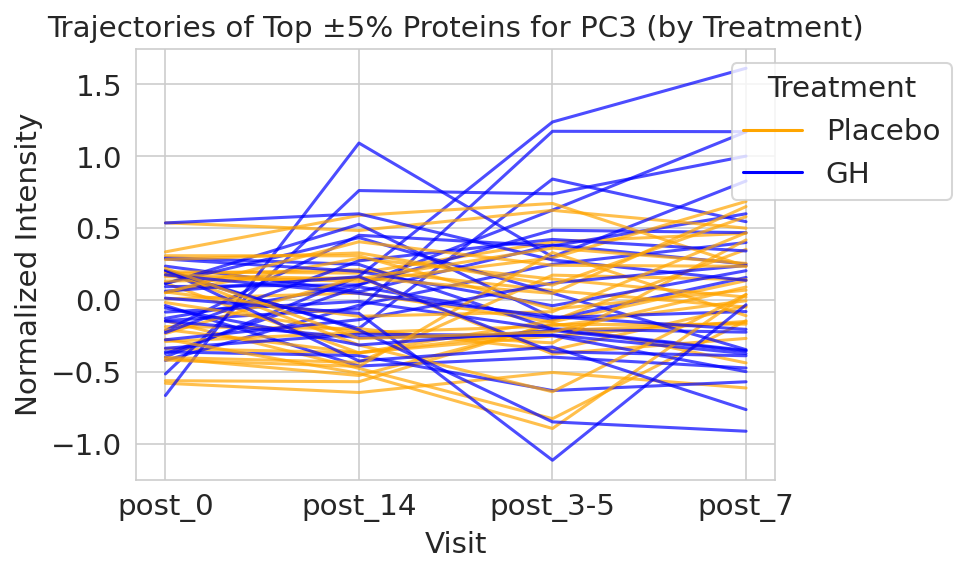

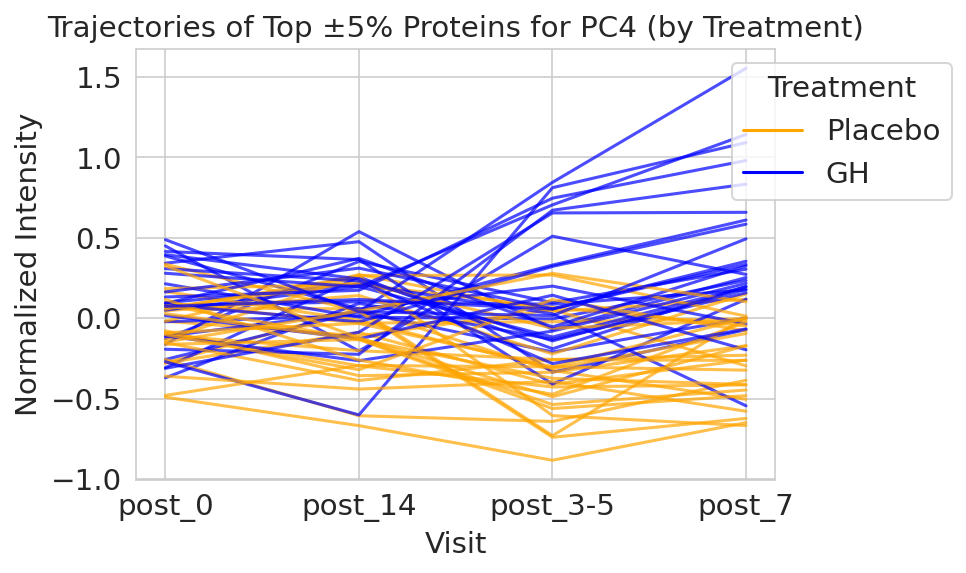

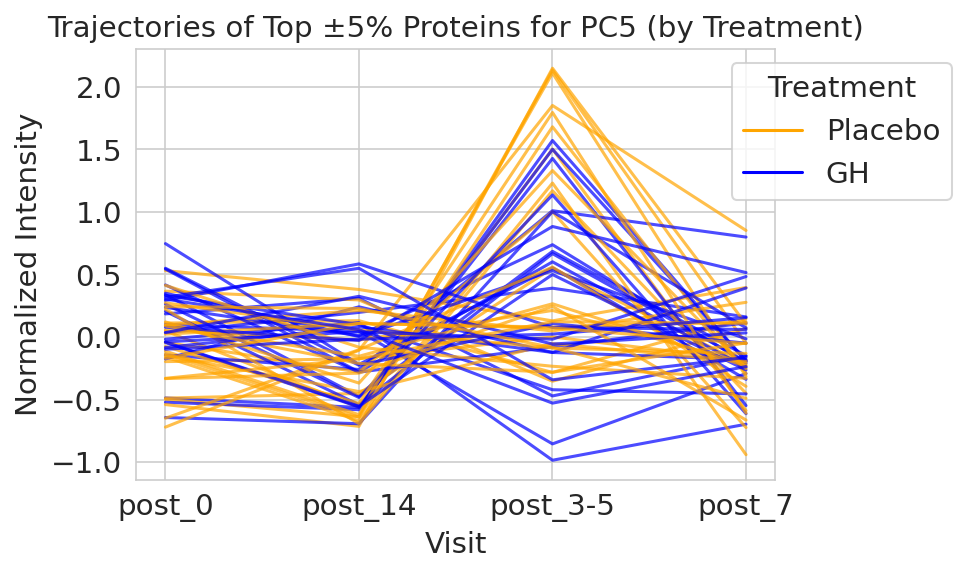

In [77]:
#plot trajectories over multiple visits
treatment_colors = {'Placebo': 'orange', 'GH': 'blue'}

for pc in ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']:
    top_proteins = top_proteins_by_pc[pc].index

    plt.figure(figsize=(7,4))
    for protein in top_proteins:
        plot_df = meta.copy()
        plot_df['intensity'] = proteomes_impnorm_noout[protein]
        for treatment in plot_df['treatment'].unique():
            group = plot_df[plot_df['treatment'] == treatment]
            means = group.groupby('visit')['intensity'].mean()
            plt.plot(means.index, means.values,
                     color=treatment_colors.get(treatment, 'gray'),
                     alpha=0.7)

    for treatment, color in treatment_colors.items():
        plt.plot([], [], color=color, label=treatment)

    plt.title(f"Trajectories of Top ±5% Proteins for {pc} (by Treatment)")
    plt.xlabel('Visit')
    plt.ylabel('Normalized Intensity')
    plt.legend(title='Treatment', loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.tight_layout()
    plt.show()


Without subject centering, these plots show a fairly clear separation between subjects treated with GH and subjects that received the placebo. However, after subject centering this distinction is much harder to see. This suggests that it is probably better to avoid subject centering when studying the effects of the treatment with GH.

##UMAP

With UMAP we can see how observations are clustered, and further examine the effects of our data preparation strategies.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


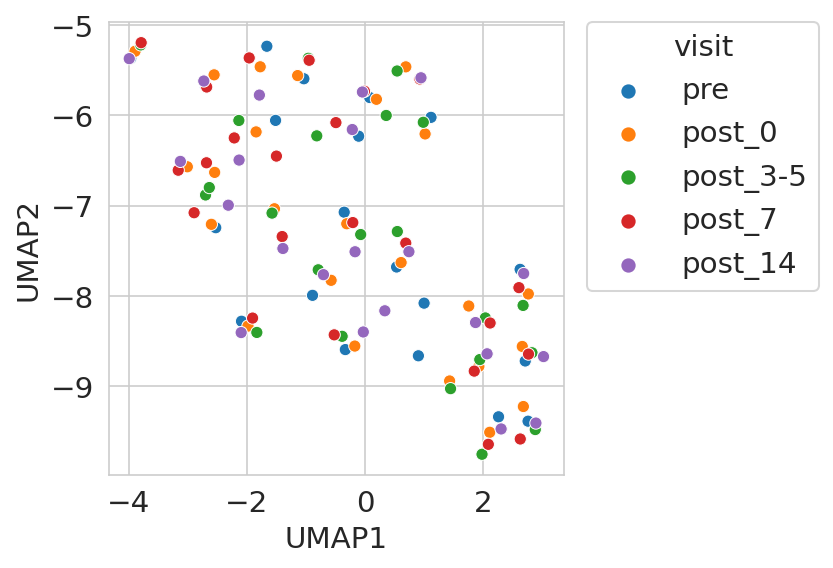

In [78]:
#UMAP plot
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(proteomes_impnorm_noout)

umap_df = pd.DataFrame(embedding, index=proteomes_impnorm_noout.index, columns=['UMAP1', 'UMAP2'])
umap_df = umap_df.join(meta[['visit']])

plt.figure(figsize=(4,4))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='visit', palette='tab10')
plt.legend(title='visit', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


Before subject centering, observations are mostly clustered by `subject`, but there is still some discernible `treatment` clustering. However, there seem to be no clusters based on other variables like `visit`.

After subject centering all `subject` clustering disappears, and the `treatment` clusters seem less discernible. This favors other variables like `visit`.

This means that in order to study treatment effects it is better to use the uncentered dataset, but if we want to study how muscle damage/recovery progresses over time it is better to use the centered dataset. However, since the main goal is to study the effects of treatment, let's keep the non centered dataset for now.

#Mixed Linear Models

<font color='red'>**Disclaimer:** the subsections in this chapter can be ran in any order, they do not need to be ran consequently.</font>

In [122]:
import sys
import pandas as pd, numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from collections import defaultdict

##Visit


Since we are using the non subject centered dataset, the best way to take subject effect into account is by using a mixed linear model and model `subject` as the random intercept.

In [105]:
#prepare dataframe each time
meta = pd.read_csv('/content/drive/My Drive/rhabdomyolysis/meta.csv', index_col=0)
proteomes_impnorm_noout = pd.read_csv('/content/drive/My Drive/rhabdomyolysis/proteomes_impnorm_noout.csv', index_col=0)
meta_use = meta.copy()
meta_use['visit'] = pd.Categorical(
        meta_use['visit'],
        categories=['pre', 'post_0', 'post_3-5', 'post_7', 'post_14'],
        ordered=True)
meta_use['subject'] = meta_use['subject'].astype('category')

expr = proteomes_impnorm_noout.loc[meta_use.index]

#1 table per each phase
cols = ['protein', 'log2FC', 'pval']
out_tables = {v: [] for v in ['post_0', 'post_3-5', 'post_7', 'post_14']}

#per-protein mixed model
for prot in expr.columns:
    df = meta_use.assign(intensity = expr[prot].values)
    try:
        fit  = smf.mixedlm("intensity ~ visit", df, groups=df["subject"]).fit(reml=False)
        betas = fit.params.filter(like='visit')
        pvals = fit.pvalues.filter(like='visit')
        for term in betas.index:
            visit = term.split('[T.')[1][:-1]
            out_tables[visit].append(
                dict(zip(cols, [prot, betas[term], pvals[term]]))
            )
    except Exception: #convergence or singular fit?
        print(prot, Exception)
        continue

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

In [106]:
#multiple testing correction
dfs = {}
for visit, lst in out_tables.items():
    tmp = pd.DataFrame(lst)
    tmp['FDR'] = multipletests(tmp['pval'], method='fdr_bh')[1]
    dfs[visit] = tmp.sort_values('FDR')
    #tmp.to_csv(f"/content/drive/My Drive/rhabdomyolysis/04_DEA/log2FC_{visit}.csv", index=False)

df_post0  = dfs['post_0']
df_post35 = dfs['post_3-5']
df_post7  = dfs['post_7']
df_post14 = dfs['post_14']

Even after FRD correction, ~ half of the features are significant for each visit-vs-baseline. This might be because there is a correlation in the expression of many proteins (eg. similar pathways), or because rhabdomyolysis is a global stressor affecting multiple pathways.


###Phase Assignment

By filtering, at each phase, the proteins that have significant p value for that phase and a log fold change > 0.5 for the first time at that phase, we can assign proteins to the phase where they first arise/drop.

In [84]:
P_FDR = 0.05  #significance
FC_MIN = 0.5  #log2FC threshold
ordered_visits = ['post_0', 'post_3-5', 'post_7', 'post_14']
phase_label = dict(zip(ordered_visits, ['acute', 'early', 'mid', 'late']))
phase_sets = {lab: [] for lab in phase_label.values()}
seen_so_far = set()

#phase assignment
for v in ordered_visits:
    dfv = dfs[v]
    mask = (dfv['FDR'] < P_FDR) & (dfv['log2FC'].abs() > FC_MIN)
    candidates = set(dfv.loc[mask, 'protein'])
    # exclude proteins that were significant earlier
    unique_to_phase = candidates - seen_so_far
    phase_name = phase_label[v]
    phase_sets[phase_name] = list(unique_to_phase)
    seen_so_far.update(unique_to_phase)



In [85]:
#individual tables with proper names
phase_tables = {}
for visit_code in ordered_visits:
    phase_name = phase_label[visit_code]
    proteins_set = phase_sets[phase_name]
    phase_tables[phase_name] = (
        dfs[visit_code]
        .loc[dfs[visit_code]['protein'].isin(proteins_set)]
        .copy()
    )

phase_acute = phase_tables['acute']
phase_early = phase_tables['early']
phase_mid   = phase_tables['mid']
phase_late  = phase_tables['late']

In [ ]:
#save all in 1 file
full_phase_df = (pd.concat(phase_tables, names=['phase']).reset_index(level='phase'))
full_phase_df.to_csv("/content/drive/My Drive/rhabdomyolysis/04_DEA/phase_specific_signatures.csv", index=False)

print("Proteins per phase:", {k: len(v) for k, v in phase_sets.items()})

Proteins per phase: {'acute': 12, 'early': 86, 'mid': 19, 'late': 0}


##Treatment

In [115]:
#prepare dataset & setup
meta = pd.read_csv('/content/drive/My Drive/rhabdomyolysis/meta.csv', index_col=0)
proteomes_impnorm_noout = pd.read_csv('/content/drive/My Drive/rhabdomyolysis/proteomes_impnorm_noout.csv', index_col=0)

meta_use = meta.copy()
meta_use = (
    meta_use.query("visit != 'pre'")  #drop baseline because it has neither placebo nor GH
            .loc[meta_use["treatment"].isin(["GH", "Placebo"])]
            .copy())

meta_use["treatment"] = pd.Categorical(meta_use["treatment"], categories=["Placebo", "GH"], ordered=True)
meta_use["subject"] = meta_use["subject"].astype("category")

proteomes_impnorm_noout.columns = (proteomes_impnorm_noout.columns.str.split(';').str[0])

expr = proteomes_impnorm_noout.loc[meta_use.index]
cols = ["protein", "log2FC", "pval"]
results = []

In [116]:
#mixed LM on treatment with subject as confounder
for prot in expr.columns:
    df = meta_use.assign(intensity=expr[prot].values)
    try:
        fit = smf.mixedlm("intensity ~ treatment", df, groups=df["subject"]).fit(reml=False)

        beta = fit.params.get("treatment[T.GH]")   # GH vs Placebo
        pval = fit.pvalues.get("treatment[T.GH]")

        results.append(dict(zip(cols, [prot, beta, pval])))

    except Exception as e:
        print(f"{prot}: {e}")
        continue

out_df = pd.DataFrame(results)
out_df["fdr"] = multipletests(out_df["pval"], method="fdr_bh")[1] #multiple test P value correction


ValueError: Expected a 1D array, got an array with shape (90, 2)

In [ ]:
out_df.to_csv('/content/drive/My Drive/rhabdomyolysis/04_DEA/protein_treatment_mixedlm_results.csv', index=False)

20 proteins associated with treatment with a significant FDR

##Visit * Treatment

In [123]:
#prepare DF & setup
meta = pd.read_csv('/content/drive/My Drive/rhabdomyolysis/meta.csv', index_col=0)
proteomes_impnorm_noout = pd.read_csv('/content/drive/My Drive/rhabdomyolysis/proteomes_impnorm_noout.csv', index_col=0)
meta_use = meta.copy()


treat_map = ( #subject-treatment lookup
    meta_use
      .query("visit == 'pre'")
      .dropna(subset=["treatment"])
      .loc[lambda d: d["treatment"].isin(["GH", "Placebo"])]
      .set_index("subject")["treatment"]
)

mask = (meta_use["visit"] == "pre") & (meta_use["treatment"].isna())
meta_use.loc[mask, "treatment"] = meta_use.loc[mask, "subject"].map(treat_map)
meta_use = (meta_use.loc[meta_use["treatment"].isin(["GH", "Placebo"])].dropna(subset=["treatment", "visit", "subject"]).copy())

#tidy the categorical encoding so the contrasts behave
meta_use["visit"] = pd.Categorical(
    meta_use["visit"],
    categories=["pre", "post_0", "post_3-5", "post_7", "post_14"],
    ordered=True,
)
meta_use["treatment"] = pd.Categorical(
    meta_use["treatment"],
    categories=["Placebo", "GH"],
)
meta_use["subject"] = meta_use["subject"].astype("category")


In [124]:
expr = proteomes_impnorm_noout.loc[meta_use.index]
records = []
failed = defaultdict(int)

#fit per protein
for prot in expr.columns:
    df = meta_use.assign(intensity = expr[prot].values)

    try:
        fit = smf.mixedlm("intensity ~ C(visit)*C(treatment)",
                          data   = df,
                          groups = df["subject"]
                         ).fit(reml=False, method='lbfgs', maxiter=200)

        for term in fit.params.index:
            if ':' in term:
                records.append({
                    'protein' : prot,
                    'term'    : term,
                    'beta'    : fit.params[term],
                    'pval'    : fit.pvalues[term],
                    'se'      : fit.bse[term]
                })

    except Exception as e:
        failed[str(e).split(':')[0].strip()] += 1
        continue

results_df = pd.DataFrame.from_records(records)

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2054: User

In [125]:
#multiple testing correction
if not results_df.empty:
    results_df['FDR'] = multipletests(results_df['pval'],
                                      method='fdr_bh')[1]
    results_df = results_df.sort_values(['term','FDR'])

    #results_df.to_csv("visit_treatment_interaction_results.csv", index=False)
    display(results_df.head())

else:
    print("FAILED:")
    print(dict(failed))


,protein,term,beta,pval,se,FDR
0,A0A804HIW2;A0A067XG54,C(visit)[T.post_0]:C(treatment)[T.GH],0.033,1.000,"4,046,816.764",NaN
4,A0A075B6H7;A0A0C4DH90;A0A0C4DH55;P01624,C(visit)[T.post_0]:C(treatment)[T.GH],-0.068,1.000,"8,388,608.000",NaN
8,A0A075B6I0,C(visit)[T.post_0]:C(treatment)[T.GH],0.294,1.000,"2,336,430.748",NaN
12,A0A075B6I1,C(visit)[T.post_0]:C(treatment)[T.GH],-0.163,1.000,"6,849,269.751",NaN
16,A0A075B6J1,C(visit)[T.post_0]:C(treatment)[T.GH],-0.170,NaN,NaN,NaN


In [126]:
results_df.to_csv("/content/drive/My Drive/rhabdomyolysis/04_DEA/visit_treatment_interaction_results.csv", index=False)

In [130]:
ALPHA_FDR = 0.05  #significance cut-off for the interaction term

sig = results_df.query("FDR <= @ALPHA_FDR").copy()
sig['visit'] = (sig['term'].str.extract(r'C\(visit\)\[T\.(.*?)\]', expand=False))

#95% wald confidence intervals
sig['ci_low']  = sig['beta'] - 1.96*sig['se']
sig['ci_high'] = sig['beta'] + 1.96*sig['se']

visits = sig['visit'].unique().tolist()


In [131]:
#forest plots
for v in visits:
    tmp = sig.loc[sig['visit'] == v].sort_values('beta')
    y_pos = range(len(tmp))
    fig, ax = plt.subplots(figsize=(6, 0.25*len(tmp)+1))

    ax.errorbar(x=tmp['beta'],
                y=y_pos,
                xerr=[tmp['beta']-tmp['ci_low'], tmp['ci_high']-tmp['beta']],
                fmt='o', capsize=3)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(tmp['protein'])
    ax.axvline(0, ls='--')
    ax.set_xlabel("β  (GH effect vs Placebo)")
    ax.set_title(f"GH × Visit interaction\nvisit = {v}   (FDR ≤ {ALPHA_FDR})")
    fig.tight_layout()
    plt.show()

##CK

In [135]:
#prepare DF and setup
meta_use = meta.copy()
meta_use['subject'] = meta_use['subject'].astype('category')

meta_use = meta_use.rename(columns={'CK (U/L)': 'CK'})
meta_use['CK'] = pd.to_numeric(meta_use['CK'], errors='coerce')

expr = proteomes_impnorm_noout.loc[meta_use.index]

cols = ['protein', 'beta', 'pval']
out_table = []

In [70]:
#per protein mixed model on CK with subject as confounder
for prot in expr.columns:

    df = meta_use.assign(intensity=expr[prot].values)
    df = df.dropna(subset=['CK', 'intensity', 'subject'])

    try:
        fit = smf.mixedlm("intensity ~ CK", df, groups=df["subject"]).fit(reml=False)
        out_table.append(dict(zip(cols, [prot, fit.params['CK'], fit.pvalues['CK']])))

    except Exception as e:
        print(f"Error for protein {prot}: {str(e)}")
        continue

results_df = pd.DataFrame(out_table)

if not results_df.empty:
    results_df['pval'] = pd.to_numeric(results_df['pval'], errors='coerce')
    results_df['FDR'] = multipletests(results_df['pval'], method='fdr_bh')[1]
    results_df = results_df.sort_values('FDR')


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

In [72]:
results_df.to_csv("/content/drive/My Drive/rhabdomyolysis/04_DEA/sc_protein_CK_mixedlm_results.csv", index=False)

164 significative FDR without subject centering.


#Predicting Long Term Outcomes From Day 0 Protein Intensities

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import LeaveOneOut, cross_val_score, KFold
from sklearn.utils import resample
from sklearn.cross_decomposition import PLSRegression

##Spearman Correlation

###Mean & Peak CK

In [79]:
#prepare DF & setup
meta_clean = meta.copy()
meta_clean['CK (U/L)'] = pd.to_numeric(meta_clean['CK (U/L)'], errors='coerce')
meta_post0 = meta_clean[meta_clean['visit'] == 'post_0'].copy()
subjects = meta_post0['subject']

ck_by_subject = (
    meta_clean.groupby('subject')['CK (U/L)']
    .agg(['max', 'mean'])
    .rename(columns={'max': 'CK_peak', 'mean': 'CK_mean'})
)

#map peak and mean CK to each post_0 sample
meta_post0['CK_peak'] = meta_post0['subject'].map(ck_by_subject['CK_peak'])
meta_post0['CK_mean'] = meta_post0['subject'].map(ck_by_subject['CK_mean'])

#extract expression matrix for post_0 samples
proteomes_post0 = proteomes_impnorm_noout.loc[meta_post0.index]

#for each protein, correlate post_0 abundance with CK_peak and CK_mean
results = []
for protein in proteomes_post0.columns:
    x = proteomes_post0[protein].values
    y_peak = meta_post0['CK_peak'].values
    y_mean = meta_post0['CK_mean'].values

    mask_peak = ~np.isnan(x) & ~np.isnan(y_peak)
    mask_mean = ~np.isnan(x) & ~np.isnan(y_mean)

    rho_peak, p_peak = spearmanr(x[mask_peak], y_peak[mask_peak]) if mask_peak.sum() > 2 else (np.nan, np.nan)
    rho_mean, p_mean = spearmanr(x[mask_mean], y_mean[mask_mean]) if mask_mean.sum() > 2 else (np.nan, np.nan)

    results.append({'protein': protein,
                    'rho_CK_peak': rho_peak, 'p_CK_peak': p_peak,
                    'rho_CK_mean': rho_mean, 'p_CK_mean': p_mean})

df_ckcorr = pd.DataFrame(results)

#multiple testing correction
df_ckcorr['FDR_CK_peak'] = multipletests(df_ckcorr['p_CK_peak'], method='fdr_bh')[1]
df_ckcorr['FDR_CK_mean'] = multipletests(df_ckcorr['p_CK_mean'], method='fdr_bh')[1]

#df_ckcorr.to_csv('/content/drive/My Drive/rhabdomyolysis/04_DEA/CK_correlation_post0.csv', index=False)
print(df_ckcorr.sort_values('FDR_CK_peak').head())
print(df_ckcorr.sort_values('FDR_CK_mean').head())


                                               protein  rho_CK_peak  \
7                                           A0A075B6J9     0.646087   
563  Q9UBE0;Q9UBE0-2;Q9UBE0-3;A0A590UKC5;A0A590UKA0...     0.557391   
219                      P04075;J3KPS3;H3BR68;P04075-2    -0.555652   
521  Q8WZ42;Q8WZ42-2;Q8WZ42-3;Q8WZ42-4;Q8WZ42-5;Q8W...    -0.580000   
348                                    P20742;P20742-2    -0.537391   

     p_CK_peak  rho_CK_mean  p_CK_mean  FDR_CK_peak  FDR_CK_mean  
7     0.000648     0.583478   0.002763     0.384473     0.783981  
563   0.004659     0.543478   0.006055     0.714180     0.783981  
219   0.004817    -0.588696   0.002476     0.714180     0.783981  
521   0.002970    -0.553043   0.005063     0.714180     0.783981  
348   0.006767    -0.516522   0.009762     0.802601     0.783981  
                                               protein  rho_CK_peak  \
591                                             Q9Y6Z7     0.466087   
546                       Q9B

Zero correlated proteins

###Day 3-5 CK

In [75]:
#prepare dataset
meta_clean = meta.copy()
meta_post0 = meta_clean[meta_clean['visit'] == 'post_0'].copy()
meta_post7 = meta_clean[meta_clean['visit'] == 'post_3-5'].copy()

meta_post0['subject'] = meta_post0['subject'].astype(str)
meta_post7['subject'] = meta_post7['subject'].astype(str)

meta_post7['CK (U/L)'] = pd.to_numeric(meta_post7['CK (U/L)'], errors='coerce')
ck_post7 = meta_post7.set_index('subject')['CK (U/L)']

meta_post0['ck_post3-5'] = meta_post0['subject'].map(ck_post7)

proteomes_post0 = proteomes_impnorm_noout.loc[meta_post0.index]

#calculate spearman correlation
results = []
for protein in proteomes_post0.columns:
    x = proteomes_post0[protein].values
    y = meta_post0['ck_post3-5'].values

    mask = ~np.isnan(x) & ~np.isnan(y)
    if mask.sum() > 2:
        rho, pval = spearmanr(x[mask], y[mask])
    else:
        rho, pval = np.nan, np.nan

    results.append({'protein': protein, 'rho': rho, 'pval': pval})

df_corr = pd.DataFrame(results)

#multiple testing correction
df_corr['FDR'] = multipletests(df_corr['pval'], method='fdr_bh')[1]

#df_corr.to_csv('/content/drive/My Drive/rhabdomyolysis/04_DEA/post0_protein_vs_post7_ck.csv', index=False)
print(df_corr.sort_values('FDR').head())


                                               protein       rho      pval  \
7                                           A0A075B6J9  0.848120  0.000002   
563  Q9UBE0;Q9UBE0-2;Q9UBE0-3;A0A590UKC5;A0A590UKA0...  0.691729  0.000728   
521  Q8WZ42;Q8WZ42-2;Q8WZ42-3;Q8WZ42-4;Q8WZ42-5;Q8W... -0.654135  0.001755   
348                                    P20742;P20742-2 -0.651128  0.001874   
556                                      Q9UHG2;Q9NPY3  0.583459  0.006923   

          FDR  
7    0.001377  
563  0.215996  
521  0.277768  
348  0.277768  
556  0.684193  


1 protein found with the subject centered dataset!!!

`A0A075B6J9` with FDR = 0.001377

###Dystrophy

In [80]:
#prepare dataset
meta_clean = meta.copy()
meta_post0 = meta_clean[meta_clean['visit'] == 'post_0'].copy()
meta_post7 = meta_clean[meta_clean['visit'] == 'post_7'].copy()

meta_post0['subject'] = meta_post0['subject'].astype(str)
meta_post7['subject'] = meta_post7['subject'].astype(str)

meta_post7['dystrophy (%)'] = pd.to_numeric(meta_post7['dystrophy (%)'], errors='coerce')
dystrophy_post7 = meta_post7.set_index('subject')['dystrophy (%)']

meta_post0['dystrophy_post7'] = meta_post0['subject'].map(dystrophy_post7)

proteomes_post0 = proteomes_impnorm_noout.loc[meta_post0.index]

#calculate spearman correlation
results = []
for protein in proteomes_post0.columns:
    x = proteomes_post0[protein].values
    y = meta_post0['dystrophy_post7'].values

    mask = ~np.isnan(x) & ~np.isnan(y)
    if mask.sum() > 2:
        rho, pval = spearmanr(x[mask], y[mask])
    else:
        rho, pval = np.nan, np.nan

    results.append({'protein': protein, 'rho': rho, 'pval': pval})

df_corr = pd.DataFrame(results)

#multiple testing correction
df_corr['FDR'] = multipletests(df_corr['pval'], method='fdr_bh')[1]

#df_corr.to_csv('/content/drive/My Drive/rhabdomyolysis/04_DEA/post0_protein_vs_post7_dystrophy.csv', index=False)
print(df_corr.sort_values('FDR').head())


               protein       rho      pval      FDR
114             P00488  0.660806  0.001110  0.65829
16   A2NJV5;A0A075B6S2  0.490717  0.023903  0.85334
502    Q7Z7M0;Q7Z7M0-2  0.576739  0.006201  0.85334
556      Q9UHG2;Q9NPY3  0.536986  0.012072  0.85334
246             P06310 -0.508964  0.018456  0.85334


No FDR < 0.05 when using only one time point or one observation per subject. This happens both with dystrophy and with CK. As soon as more observations per subject are used, it's easier to obtain statistically significant results. This means it's likely that more observations are gonna be needed before we can observe some meaningful results on things like prediction of day 7 dystrophy % from day 0 biomarkers.

##T-tests

###CK

In [81]:
#prepare dataset
meta_clean = meta.copy()
meta_clean = meta_clean.rename(columns={'CK (U/L)': 'CK'})
meta_post0 = meta_clean[meta_clean['visit'] == 'post_0'].copy()
meta_post3 = meta_clean[meta_clean['visit'] == 'post_3-5'].copy()

meta_post0['subject'] = meta_post0['subject'].astype(str)
meta_post3['subject'] = meta_post3['subject'].astype(str)

meta_post3['CK'] = pd.to_numeric(meta_post3['CK'], errors='coerce')
ck_post3 = meta_post3.set_index('subject')['CK']

meta_post0['CK'] = meta_post0['subject'].map(ck_post3)

#define groups
median_thresh = meta_post0['CK'].median()
meta_post0['CK_group'] = np.where(meta_post0['CK'] > median_thresh, 'High', 'Low')

proteomes_post0 = proteomes_impnorm_noout.loc[meta_post0.index]

#per protein t-test
results = []
for protein in proteomes_post0.columns:
    x = proteomes_post0[protein].values
    group = meta_post0['CK_group'].values

    mask = ~np.isnan(x) & ~pd.isna(group)
    if mask.sum() > 2:
        group_high = x[(group == 'High') & mask]
        group_low  = x[(group == 'Low') & mask]
        if len(group_high) > 1 and len(group_low) > 1:
            stat, pval = ttest_ind(group_high, group_low, equal_var=False)
        else:
            stat, pval = np.nan, np.nan
    else:
        stat, pval = np.nan, np.nan

    results.append({'protein': protein, 't_stat': stat, 'pval': pval})

df_ttest = pd.DataFrame(results)

#multiple testing correction
df_ttest['FDR'] = multipletests(df_ttest['pval'], method='fdr_bh')[1]

#df_ttest.to_csv('/content/drive/My Drive/rhabdomyolysis/04_DEA/post0_ttest_ck.csv', index=False)
print(df_ttest.sort_values('FDR').head())


                                               protein    t_stat      pval  \
563  Q9UBE0;Q9UBE0-2;Q9UBE0-3;A0A590UKC5;A0A590UKA0...  3.416831  0.003577   
521  Q8WZ42;Q8WZ42-2;Q8WZ42-3;Q8WZ42-4;Q8WZ42-5;Q8W... -3.860416  0.001579   
219                      P04075;J3KPS3;H3BR68;P04075-2 -3.501184  0.002024   
201                                             P02763 -3.225741  0.003892   
7                                           A0A075B6J9  3.327672  0.004083   

          FDR  
563  0.420547  
521  0.420547  
219  0.420547  
201  0.420547  
7    0.420547  


###Dystrophy

In [82]:
#prepare data
meta_clean = meta.copy()
meta_post0 = meta_clean[meta_clean['visit'] == 'post_0'].copy()
meta_post7 = meta_clean[meta_clean['visit'] == 'post_7'].copy()

meta_post0['subject'] = meta_post0['subject'].astype(str)
meta_post7['subject'] = meta_post7['subject'].astype(str)

meta_post7['dystrophy (%)'] = pd.to_numeric(meta_post7['dystrophy (%)'], errors='coerce')
dystrophy_post7 = meta_post7.set_index('subject')['dystrophy (%)']

meta_post0['dystrophy_post7'] = meta_post0['subject'].map(dystrophy_post7)

median_thresh = meta_post0['dystrophy_post7'].median()
meta_post0['dystrophy_group'] = np.where(meta_post0['dystrophy_post7'] > median_thresh, 'High', 'Low')

proteomes_post0 = proteomes_impnorm_noout.loc[meta_post0.index]

#per protein T test
results = []
for protein in proteomes_post0.columns:
    x = proteomes_post0[protein].values
    group = meta_post0['dystrophy_group'].values

    mask = ~np.isnan(x) & ~pd.isna(group)
    if mask.sum() > 2:
        group_high = x[(group == 'High') & mask]
        group_low  = x[(group == 'Low') & mask]
        if len(group_high) > 1 and len(group_low) > 1:
            stat, pval = ttest_ind(group_high, group_low, equal_var=False)
        else:
            stat, pval = np.nan, np.nan
    else:
        stat, pval = np.nan, np.nan

    results.append({'protein': protein, 't_stat': stat, 'pval': pval})

df_ttest = pd.DataFrame(results)

#multiple testing correction
df_ttest['FDR'] = multipletests(df_ttest['pval'], method='fdr_bh')[1]


#df_ttest.to_csv('/content/drive/My Drive/rhabdomyolysis/04_DEA/post0_ttest_dystrophy.csv', index=False)
print(df_ttest.sort_values('FDR').head())


                                               protein    t_stat      pval  \
193     P02746;D6R934;A0A0A0MSV6;A0A8Q3WM25;A0A8Q3SI33  3.626280  0.001548   
377  Q15723;Q99607;P32519;A0A0U1RRL5;P32519-2;D6RHI...  0.607331  0.551773   
399  P43251;P43251-2;P43251-3;P43251-4;A0A2R8Y5J9;C...  1.022978  0.320205   
368                                      P26927;G3XAK1  1.450177  0.162655   
370            P27487;A0A7I2V2R5;A0A7I2V2X8;A0A7I2V5R8 -0.703008  0.489847   

          FDR  
193  0.918086  
377  0.977995  
399  0.977995  
368  0.977995  
370  0.977995  


Nothing

##Lasso

###CK

In [83]:
#prepare data
meta_clean = meta.copy()
meta_clean = meta_clean.rename(columns={'CK (U/L)': 'CK'})  # clean name

meta_post0 = meta_clean[meta_clean['visit'] == 'post_0'].copy()
meta_post3 = meta_clean[meta_clean['visit'] == 'post_3-5'].copy()

meta_post0['subject'] = meta_post0['subject'].astype(str)
meta_post3['subject'] = meta_post3['subject'].astype(str)

meta_post3['CK'] = pd.to_numeric(meta_post3['CK'], errors='coerce')
ck_post3 = meta_post3.set_index('subject')['CK']
meta_post0['CK_post3'] = meta_post0['subject'].map(ck_post3)

meta_post0 = meta_post0.dropna(subset=['CK_post3'])

In [84]:
proteomes_post0 = proteomes_impnorm_noout.loc[meta_post0.index]
X = proteomes_post0
y = meta_post0['CK_post3'].values

#fit Lasso model
loo = LeaveOneOut()
model = make_pipeline(
    StandardScaler(),
    LassoCV(cv=loo, random_state=42)
)

model.fit(X, y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(cv=LeaveOneOut(), random_state=42))])

14 proteins selected:
A0A075B6J9                                                                           9785.441414
P01034                                                                               2700.875141
Q9UHG2;Q9NPY3                                                                        2611.187008
P09493;P09493-4;P09493-6;A0A0S2Z4G6;H0YKJ4;H0YK48;A0A494C0I0;P09493-10;A0A994J554   -2555.389551
Q15465                                                                               2395.227416
P12821;J3KTB8;P12821-2;P12821-3;P12821-4;A0A0A0MSN4;F6X3S4                           1654.680701
P51884                                                                               1429.528217
A2PYH4;C9JQ07;C9JA44                                                                -1214.957718
P05546                                                                               -921.252133
P11597;P11597-2;H3BRJ9                                                               -698.894372
P01011;G

<ipython-input-85-1118310dc936>:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


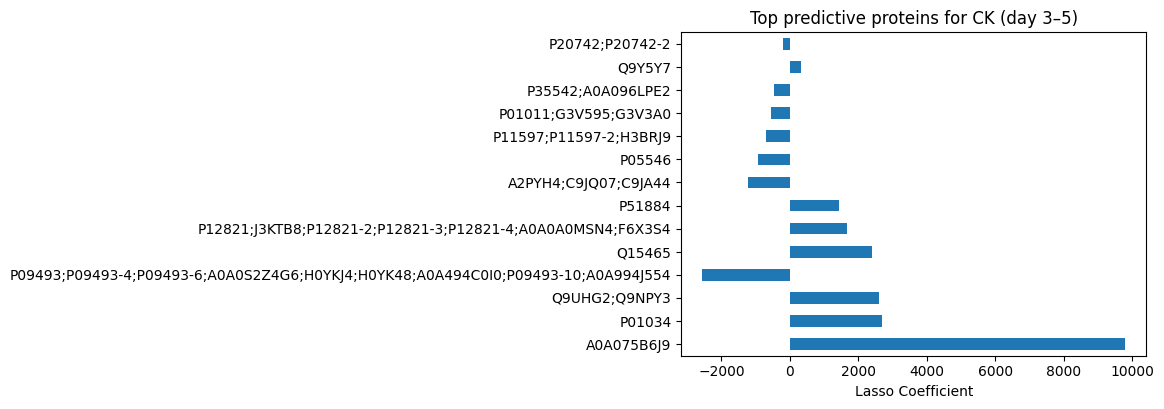

In [85]:
#extract selected proteins
lasso = model.named_steps['lassocv']
coefs = pd.Series(lasso.coef_, index=X.columns)
selected = coefs[coefs != 0].sort_values(key=np.abs, ascending=False)

print(f"{selected.shape[0]} proteins selected:")
print(selected)

#plot
if not selected.empty:
    selected.plot(kind='barh', figsize=(6, max(2, len(selected) * 0.3)))
    plt.xlabel("Lasso Coefficient")
    plt.title("Top predictive proteins for CK (day 3–5)")
    plt.tight_layout()
    plt.show()
else:
    print("No proteins selected")

When carried out on the subject-centered dataset, Lasso regression finds 14 predictors of CK:



```
A0A075B6J9
P01034
Q9UHG2                                                                      
P09493
Q15465
P12821
P51884
A2PYH4
P05546
P11597
P01011
P35542
Q9Y5Y7
P20742
```



####Bootstrapping

The Lasso model returned some proteins, but it's important to validate the stability of its performance and variable selection. In absence of more data, let's use bootstrapping with the data that is currently available.

In [32]:
X = proteomes_post0.values
y = meta_post0['CK_post3'].values

lasso = LassoCV(cv=5, random_state=1).fit(X, y)
coef = pd.Series(lasso.coef_, index=proteomes_post0.columns)

#stability selection with 1000 bootstraps
n_boot = 1000
sel_count = pd.Series(0, index=proteomes_post0.columns)
for _ in range(n_boot):
    idx = resample(range(len(y)), replace=True, random_state=_)
    lboot = LassoCV(cv=loo).fit(X[idx], y[idx])
    sel_count += (lboot.coef_ != 0)

stab_prob = sel_count / n_boot
stable_hits = stab_prob[stab_prob > 0.6].sort_values(ascending=False)

print("Selection probability for the 12 original proteins:") #12 when using CV=5
print(stab_prob[coef != 0].sort_values(ascending=False))

NameError: name 'proteomes_post0' is not defined

Lasso on the subject centered dataset finds 12 proteins with 5 fold CV, and 14 proteins with LOOCV. This is promising, but these results did not replicate under bootstrapped resampling. This highlights the limits of stability of a model trained on such a small dataset. Overfitting is likely the issue.

###Dystrophy

In [87]:
#prepare data
meta_clean = meta.copy()

meta_post0 = meta_clean[meta_clean['visit'] == 'post_0'].copy()
meta_post7 = meta_clean[meta_clean['visit'] == 'post_7'].copy()

meta_post0['subject'] = meta_post0['subject'].astype(str)
meta_post7['subject'] = meta_post7['subject'].astype(str)

meta_post7['dystrophy (%)'] = pd.to_numeric(meta_post7['dystrophy (%)'], errors='coerce')
dystrophy_post7 = meta_post7.set_index('subject')['dystrophy (%)']

meta_post0['dystrophy_post7'] = meta_post0['subject'].map(dystrophy_post7)
meta_post0 = meta_post0.dropna(subset=['dystrophy_post7'])


In [88]:
proteomes_post0 = proteomes_impnorm_noout.loc[meta_post0.index]
X = proteomes_post0
y = meta_post0['dystrophy_post7'].values

#fit lasso model
loo = LeaveOneOut()
model = make_pipeline(
    StandardScaler(),
    LassoCV(cv=loo, random_state=42)
)

model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(cv=LeaveOneOut(), random_state=42))])

In [89]:
#extract selected proteins
lasso = model.named_steps['lassocv']
coefs = pd.Series(lasso.coef_, index=X.columns)
selected = coefs[coefs != 0].sort_values(key=np.abs, ascending=False)

print(f"{selected.shape[0]} proteins selected by Lasso:")
print(selected)

0 proteins selected by Lasso:
Series([], dtype: float64)


Lasso does not select any day 0 proteins for day 7 dystrophy

##PLS

<font color='red'>Not explored in detail.</font>

###CK

In [90]:
#standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PLS regression with cross-validation to choose best number of components
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
component_range = range(1, min(15, X.shape[1] + 1))

for n in component_range:
    pls = PLSRegression(n_components=n)
    pipeline = make_pipeline(StandardScaler(), pls)
    score = cross_val_score(pipeline, X, y, cv=cv, scoring='r2').mean()
    cv_scores.append(score)

best_n = component_range[np.argmax(cv_scores)]
print(f"Best number of components: {best_n} with R² = {max(cv_scores):.3f}")

Best number of components: 3 with R² = -4.305


In [91]:
#final model with best number of components
pls_final = PLSRegression(n_components=best_n)
pls_final.fit(X_scaled, y)

#get top contributing proteins
coefs = pd.Series(pls_final.coef_.ravel(), index=X.columns)
top_proteins = coefs.abs().sort_values(ascending=False).head(20)

print("Top contributing proteins to dystrophy prediction:")
print(top_proteins)

Top contributing proteins to dystrophy prediction:
P08637;H0Y755;A0A8V8TPL1;A0A8V8TQ03;A0A8V8TNB8          0.380185
A0A075B6H9                                              0.376555
P07478;Q8NHM4;P07477;E7EQ64;H0Y8D1;A0A0J9YYC8;A6XMV9    0.376471
Q13201;E7EPG1                                           0.371173
P04075;J3KPS3;H3BR68;P04075-2                           0.365864
Q9UHG2;Q9NPY3                                           0.351615
P08493;P08493-2                                         0.329810
P02452;I3L3H7                                           0.321737
Q7Z7M0;Q7Z7M0-2                                         0.314958
P06310                                                  0.304245
P01814                                                  0.299910
P02746;D6R934;A0A0A0MSV6;A0A8Q3WM25;A0A8Q3SI33          0.292148
Q86SQ4;Q86SQ4-2;Q86SQ4-3;Q86SQ4-4;F5H2L1                0.291818
P01008                                                  0.290751
P13727;P13727-2                        

`R² = -0.570` for CK and `R² = -4.305` for dystrophy.

This means it's just better to always predict the mean so the models are not good. Would require more time to fix.

#Enrichment Analysis

In [5]:
pip install gprofiler-official

In [ ]:
import pandas as pd
from gprofiler import GProfiler

##CK

In [50]:
#prepare data
df = pd.read_csv("/content/drive/My Drive/rhabdomyolysis/04_DEA/protein_CK_mixedlm_results.csv")

df = df[df["FDR"] < 0.05]
df = df[df["beta"] < 0] #CHANGE HERE FOR POSITIVE/NEGATIVE CORRELATION

df["UniProt_ID"] = df["protein"].str.split(";").str[0]
unique_ids = df["UniProt_ID"].dropna().unique().tolist()

In [74]:
#carried out on lasso results (manually written here)

#positive correlation
#unique_ids = ['A0A075B6J9', 'P01034', 'Q9UHG2', 'Q15465', 'P12821', 'P51884', 'Q9Y5Y7']

#negative correlation
unique_ids = ['P09493', 'A2PYH4', 'P05546', 'P11597', 'P01011', 'P35542', 'P20742']

In [93]:
gp = GProfiler(return_dataframe=True)

#run enrichment
results = gp.profile(
    organism="hsapiens",
    query=unique_ids,
    sources=["GO:BP", "GO:MF", "GO:CC", "KEGG", "REAC"]
)

significant = results[results["p_value"] < 0.05]


In [59]:
significant.to_csv('/content/drive/My Drive/rhabdomyolysis/05_enrichment/post3_CK_protein_negative.csv', index=False)


##Treatment * Visit

In [100]:
#prepare data
df = pd.read_csv("/content/drive/My Drive/rhabdomyolysis/04_DEA/protein_visit_treatment_mixedlm_results.csv")

df = df[df["FDR"] < 0.05].copy()
df = df[df["beta"] < 0] #CHANGE HERE FOR POSITIVE/NEGATIVE CORRELATION
df["UniProt_ID"] = df["protein"].str.split(";").str[0]
unique_ids = df["UniProt_ID"].dropna().unique().tolist()


In [101]:
gp = GProfiler(return_dataframe=True)

#run enrichment
results = gp.profile(
    organism="hsapiens",
    query=unique_ids,
    sources=["GO:BP", "GO:MF", "GO:CC", "KEGG", "REAC"]
)

significant = results[results["p_value"] < 0.05]


In [48]:
significant.to_csv('/content/drive/My Drive/rhabdomyolysis/05_enrichment/treatment_visit_protein.csv', index=False)


In [102]:
#enrichment by visit
enrichment_by_term = {}

for term, group in df.groupby("term"):
    ids = group["UniProt_ID"].dropna().unique().tolist()
    if len(ids) > 2:  # skip too-small groups (eg. post0)
        result = gp.profile(
            organism="hsapiens",
            query=ids,
            sources=["GO:BP", "GO:MF", "GO:CC", "KEGG", "REAC"]
        )
        #keep only significant terms
        significant = result[result["p_value"] < 0.05]
        if not significant.empty:
            enrichment_by_term[term] = significant
        else:
            print(f"No significant terms for {term}")



No significant terms for C(visit)[T.post_3-5]:C(treatment)[T.GH]


In [103]:
#save each enrichment result
for term, df_term in enrichment_by_term.items():
    safe_term = term.replace("C(visit)[T.", "").replace("]:C(treatment)[T.GH]", "")
    filename = f"/content/drive/My Drive/rhabdomyolysis/05_enrichment//enrichment_{safe_term}_negative.csv"
    df_term.to_csv(filename, index=False)